# Binary Classification with a Bank Churn Dataset

[This is a Kaggle competition.](https://www.kaggle.com/competitions/playground-series-s4e1)

## Playground Series - Season 4, Episode 1

**Project Goal**: For this Episode of the Series, your task is to predict whether a customer continues with their account or closes it (e.g., churns). 


**Evaluation**: Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

### Load the Workspace

In [1]:
import warnings
from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import plotly.graph_objs as go
from plotly.tools import make_subplots
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected = True)
import plotly.express as px

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.calibration import CalibratedClassifierCV

import tensorflow as tf

### Load the Data

In [2]:
train = pd.read_csv('playground-series-s4e1/train.csv')
test = pd.read_csv('playground-series-s4e1/test.csv')
sample_submission = pd.read_csv('playground-series-s4e1/sample_submission.csv')

In [3]:
train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [4]:
test.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


In [5]:
sample_submission.head()

,id,Exited
0,165034,0.5
1,165035,0.5
2,165036,0.5
3,165037,0.5
4,165038,0.5


### Data Exploration

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


In [7]:
train.describe()

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.0000,1.650340e+05,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,82516.5000,1.569201e+07,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,47641.3565,7.139782e+04,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,0.0000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,41258.2500,1.563314e+07,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,82516.5000,1.569017e+07,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,123774.7500,1.575682e+07,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,165033.0000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [8]:
train.describe(include='object')

,Surname,Geography,Gender
count,165034,165034,165034
unique,2797,3,2
top,Hsia,France,Male
freq,2456,94215,93150


The target feature is `Exited`.

**Convert Features to Appropriate Datatypes**

In [9]:
df = train.copy()

categorical_features = ['HasCrCard', 'IsActiveMember']
df[categorical_features].value_counts()

HasCrCard  IsActiveMember
1.0        0.0               63239
           1.0               61189
0.0        1.0               20960
           0.0               19646
Name: count, dtype: int64

In [10]:
df = train.iloc[:, 3:].copy()
df = df.assign(
    HasCrCard=lambda x: x.HasCrCard.astype('category'),
    IsActiveMember=lambda x: x.IsActiveMember.astype('category'),
    Geography=lambda x: x.Geography.astype('category'),
    Gender=lambda x: x.Gender.astype('category'),
    NumOfProducts=lambda x: x.NumOfProducts.astype('category'),
    Tenure=lambda x: x.Tenure.astype('category'),
    Exited=lambda x: x.Exited.astype('category'),
)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   CreditScore      165034 non-null  int64   
 1   Geography        165034 non-null  category
 2   Gender           165034 non-null  category
 3   Age              165034 non-null  float64 
 4   Tenure           165034 non-null  category
 5   Balance          165034 non-null  float64 
 6   NumOfProducts    165034 non-null  category
 7   HasCrCard        165034 non-null  category
 8   IsActiveMember   165034 non-null  category
 9   EstimatedSalary  165034 non-null  float64 
 10  Exited           165034 non-null  category
dtypes: category(7), float64(3), int64(1)
memory usage: 6.1 MB


### Visualizing the Data

**Univariate Analysis**

In [11]:
deep_colors = [
    '#2e921b', '#7f1b92', '#4C72B0', '#55A868', 
    '#C44E52', '#8172B2', '#CCB974', '#64B5CD'
]

In [12]:
def plot_data(
        data, column, plot_type='count', 
        palette=deep_colors, figsize=(10,6)
):
    fig, ax = plt.subplots(figsize=figsize)
    if plot_type == 'count':
        sns.countplot(x=column, data=data, ax=ax, palette=palette[:len(data[column].unique())], hue=column, legend=False)
        ax.set_title(f"Count Plot of {column}", size=15)
        ax.set_xlabel(column, size=12, weight='bold')
        ax.set_ylabel("Count", size=12, weight='bold')
        total = len(data[column])
        for p in ax.patches:
            height = p.get_height()
            pct = 100 * height / total
            ax.annotate(f'{pct:.1f}%', (p.get_x()+0.3, height+5), fontsize=12)
    elif plot_type == 'swarm':
        sns.swarmplot(y=column, data=data, ax=ax)
        ax.set_title(f"Swarm Plot of {column}", size=15)
        ax.set_xlabel(column, size=12, weight='bold')
        ax.set_ylabel("Value", size=12, weight='bold')
    elif plot_type == 'dist':
        sns.histplot(data=data, x=column, ax=ax, kde=True)
        ax.set_title(f"Distribution Plot of {column}", size=15)
        ax.set_xlabel(column, size=12, weight='bold')
        ax.set_ylabel("Frequency", size=12, weight='bold')
    elif plot_type == 'stacked':
        groupby_df = data.groupby(column)['Loan_Status'].value_counts(normalize=True).unstack()
        groupby_df.plot(kind='bar', stacked=True, ax=ax, color=palette)
        ax.set_title(f"Stacked Bar Plot of {column}", size=15, weight='bold')
        ax.set_xlabel(column, size=12, weight='bold')
        ax.set_ylabel("Proportion", size=12, weight='bold')
        ax.legend(title="Loan Status", loc='upper right')
        for i in range(groupby_df.shape[0]):
            for j in range(groupby_df.shape[1]):
                pct = groupby_df.iloc[i, j] * 100
                ax.annotate(f"{pct:.1f}%", xy=(i, groupby_df.iloc[i, :j].sum() + pct/2),
                            ha='center', va='center', color='white', weight='bold')
    else:
        print(f"Invalid plot type: {plot_type}")

    plt.show()

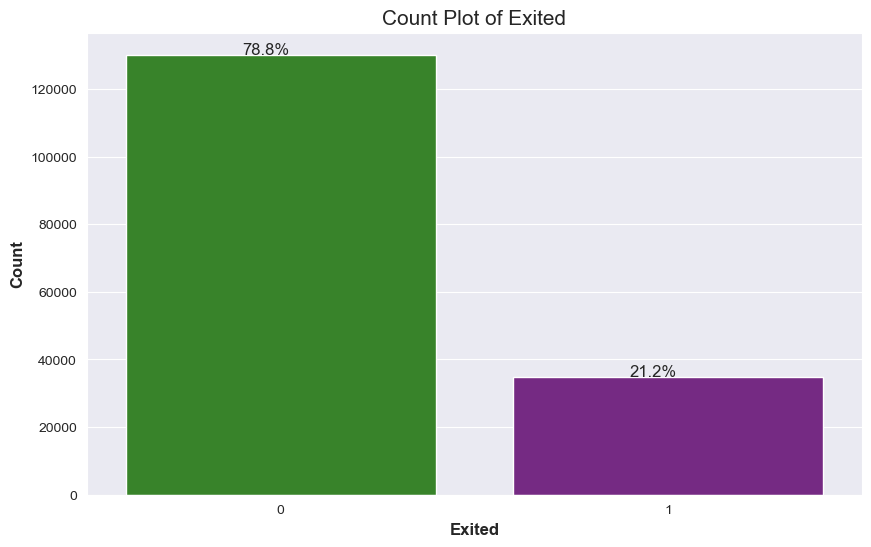

In [13]:
# Create count plot of Exited
plot_data(df, 'Exited', plot_type='count')

Based on the target countplot, we observe that:
* the majority of users in the dataset are retained.
* the ratio of retention to churn is about 80:20. This indicates an imbalanced dataset.

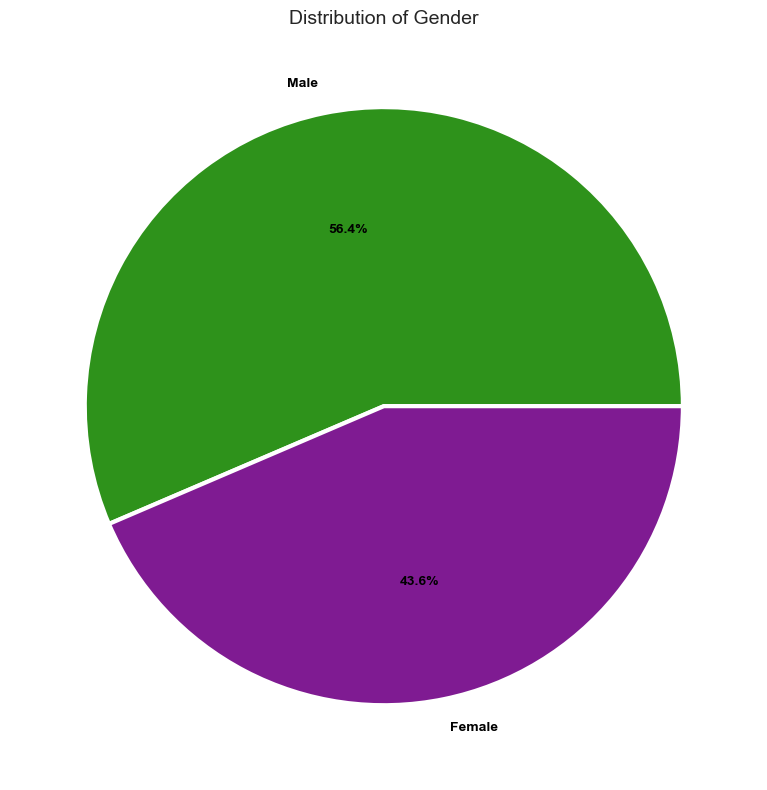

In [14]:
# Count the number of occurrences for each gender
gender_counts = df['Gender'].value_counts()

color_pie= ['#2e921b', '#7f1b92']

# Create a pie plot
# names = ['Male', 'Female']
fig, ax = plt.subplots(figsize=(12,8))
ax.pie(
    gender_counts, labels=df['Gender'].unique(), 
    autopct='%.1f%%', colors=color_pie, 
    wedgeprops={'linewidth': 3.0, 'edgecolor': '#FFFFFF'}, 
    textprops={'size': 'medium', 'color':'#000000', 'weight':'bold'}
)
ax.set_title('Distribution of Gender', fontsize=14)
plt.tight_layout()

Based on the gender pie plot:
* While a majority of the bank customers are male, the ratio of male to female customers is 56:44.

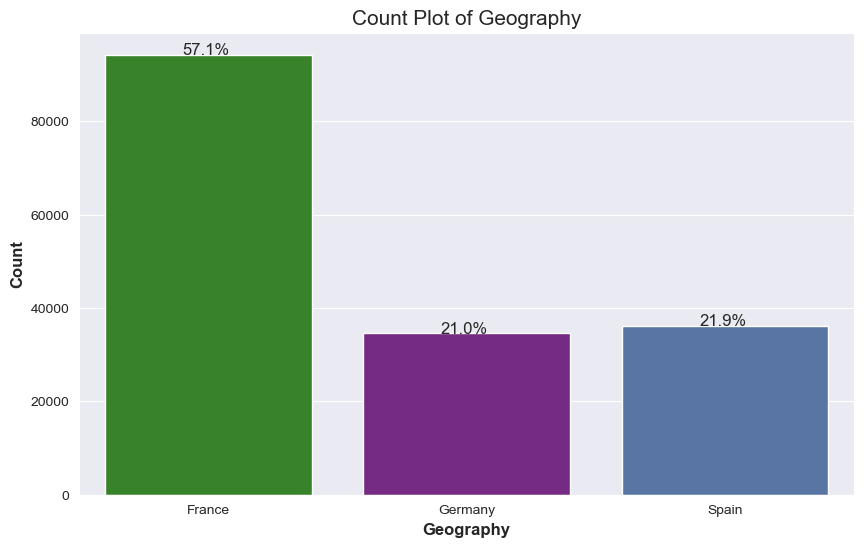

In [15]:
# Create count plot of Geography
plot_data(df, 'Geography', plot_type='count')

Based on the Geography count plot:
* More than half of the customers are from France.
* The remainder customers are equally from Germany and Spain.
* This suggests that the bank's major customer market is France.

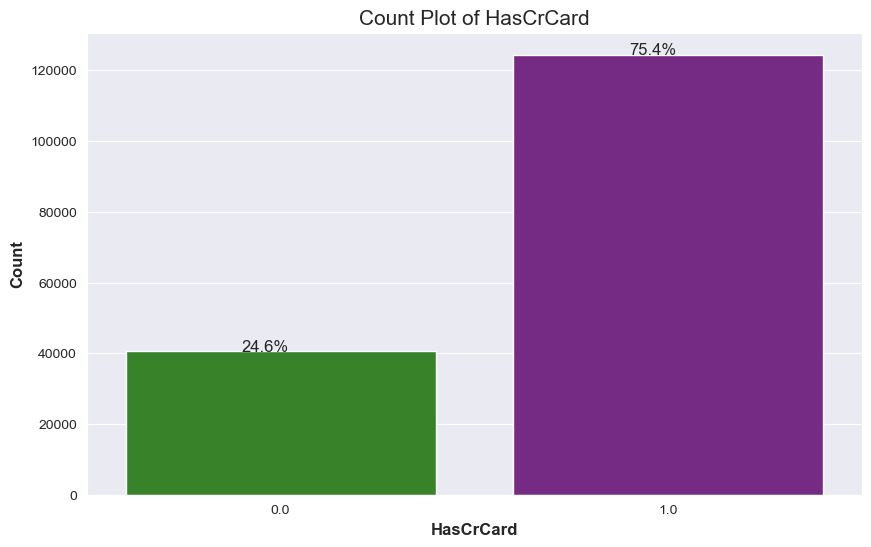

In [16]:
# Create count plot of HasCrCard
plot_data(df, 'HasCrCard', plot_type='count')

From the HasCrCard count plot:
* 3/4 of customers have a credit card.

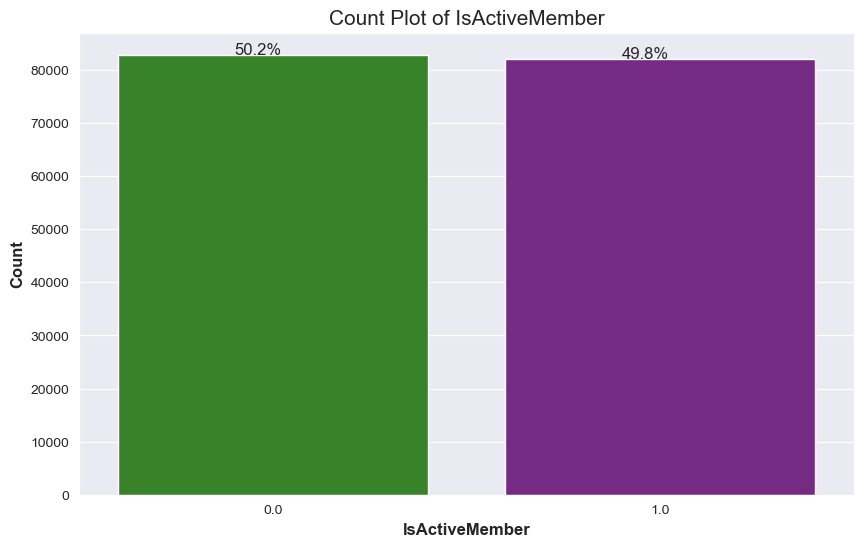

In [17]:
# Create count plot of IsActiveMember
plot_data(df, 'IsActiveMember', plot_type='count')

From the IsActiveMember count plot:
* The dataset is equally shared between customers who are active members and customers who are not.

/var/folders/t4/x7zw1vdd2gx4d5lg3pnpdnwm0000gn/T/ipykernel_8378/1048535693.py:7: UserWarning:


The palette list has fewer values (8) than needed (11) and will cycle, which may produce an uninterpretable plot.



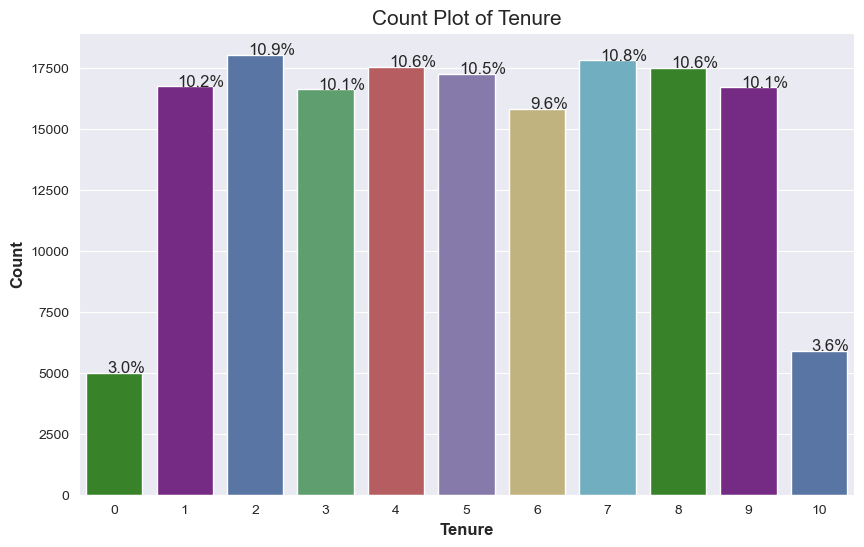

In [18]:
plot_data(df, 'Tenure', plot_type='count')

From the tenure count plot:
* Most customers have 1+ years relationship with the bank.
* The lowest relationship tenure is <1 year and >9 years.
* This feature may be highly correlated with the target variable and may significantly explain why customer retention is high.

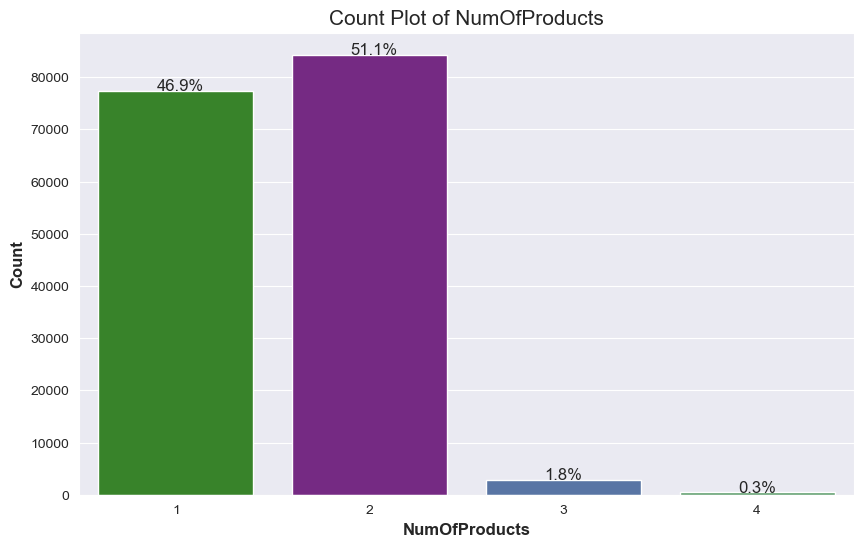

In [19]:
plot_data(df, 'NumOfProducts', plot_type='count')

From the number of products count plot:
* Most users use at least 1 product with the bank and a majority use 2 products.
* Very few customers use more than 2 products.

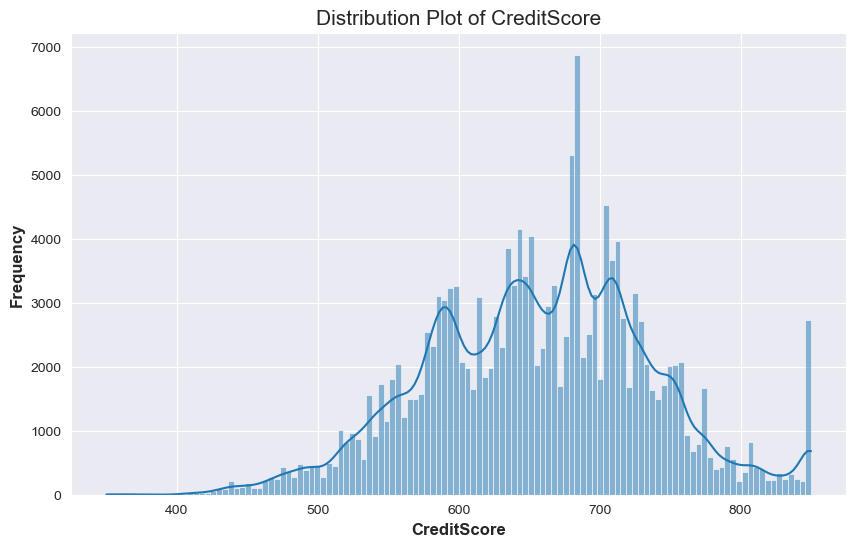

In [20]:
plot_data(df, 'CreditScore', plot_type='dist')

From the credit score histogram:
* the credit score histogram is slightly left skewed. 
* However, if the leftward outliers are removed, the distribution is approximately normal.
* This implies that most bank customers have a credit score around the mean/ median range.
* There are some outliers - some customers have low scores around 400. It will be interesting to see how that correlates with the target variable. 
* There is also a significant spike in the highest credit score range, implying that a significant number of users are in the high credit score range, higher than the amount for a normal distribution.

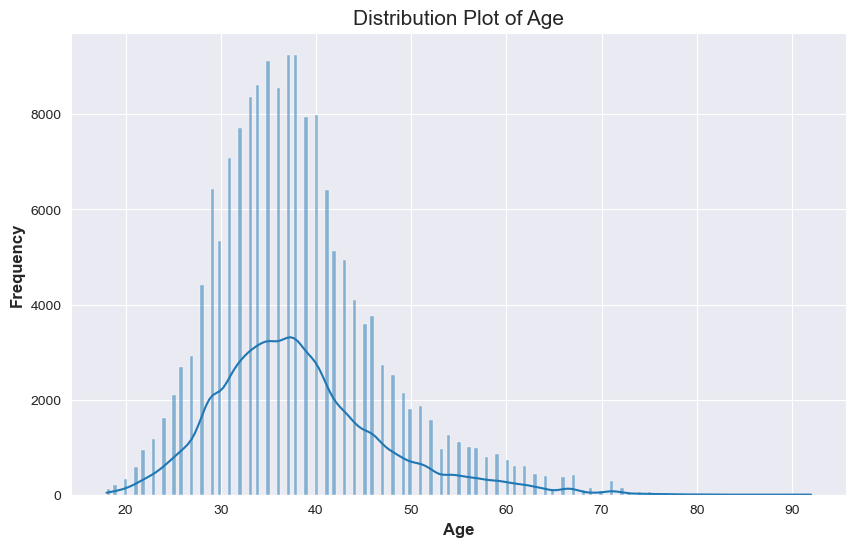

In [21]:
plot_data(df, 'Age', plot_type='dist')

From the age histogram:
* Age is right skewed, with a few customers being 70+ years in age. 
* Without the outliers, the distribution mirrors a normal distribution with most customers ages clustered around the median/ mean of 35 years old.
* All bank customers are adults.

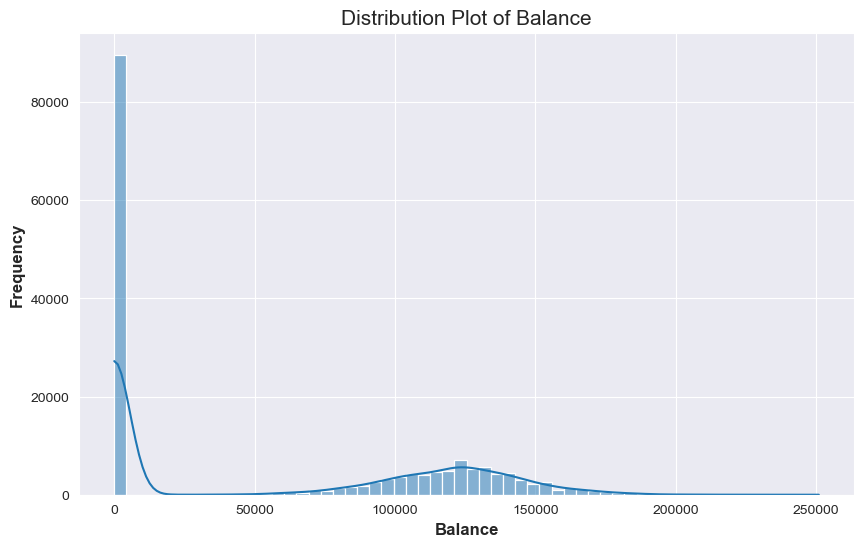

In [22]:
plot_data(df, 'Balance', plot_type='dist')

From the balance histogram:
* Most users have a balance of 0
* For the users with positive balances, the distribution is approximately normal with most user balances clustered around the mean/ median of 125k.
* No users have a negative balance.

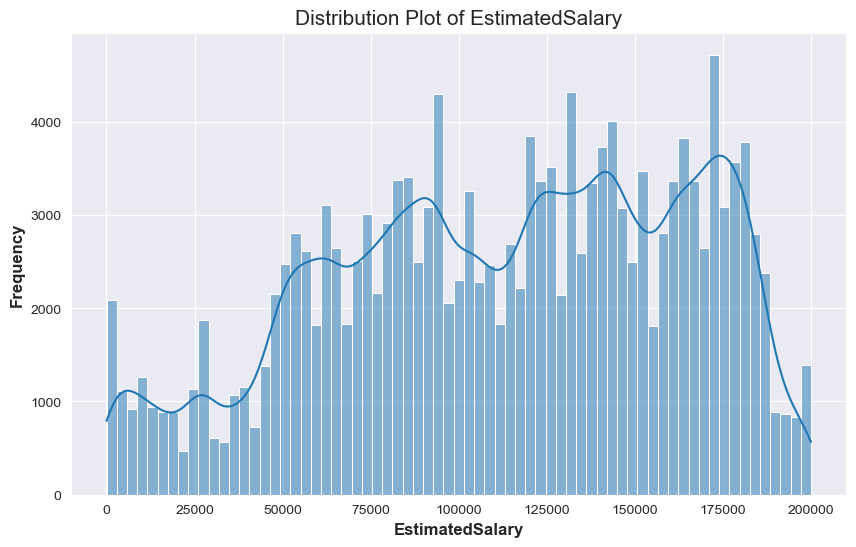

In [23]:
plot_data(df, 'EstimatedSalary', plot_type='dist')

From the estimated salary histogram:
* The spread of estimated salary across the dataset seems approximately uniform and normal.

**Conclusion after Univariate Analysis**

* Most numeric variables have outliers
* There are no missing values

**Handling Outliers**

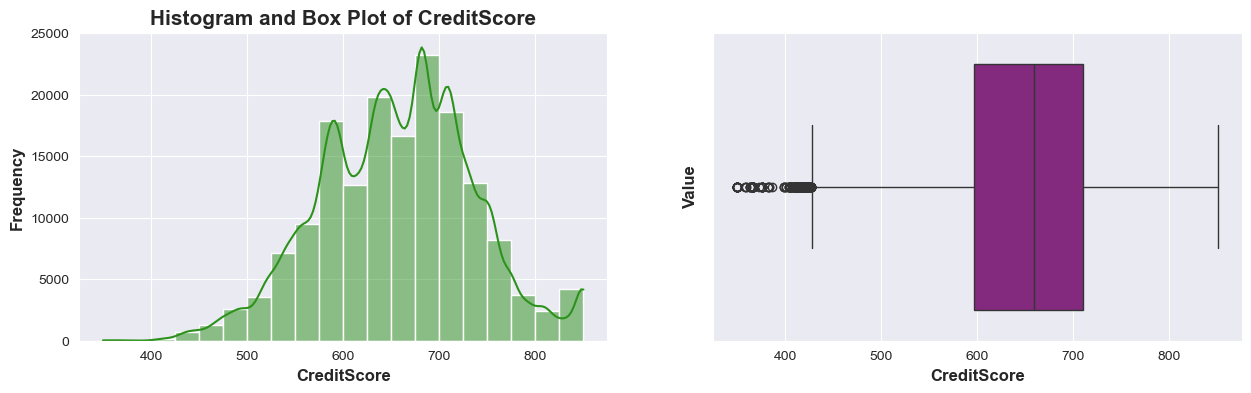

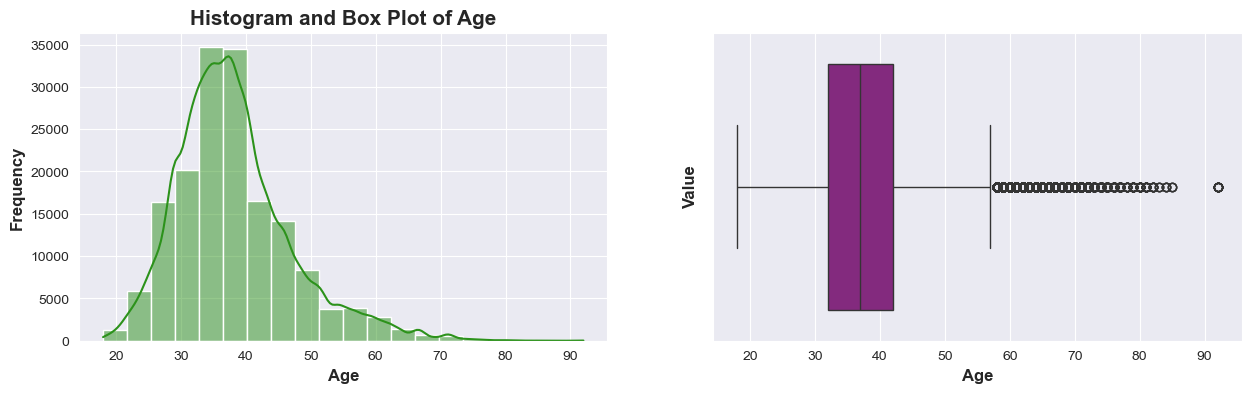

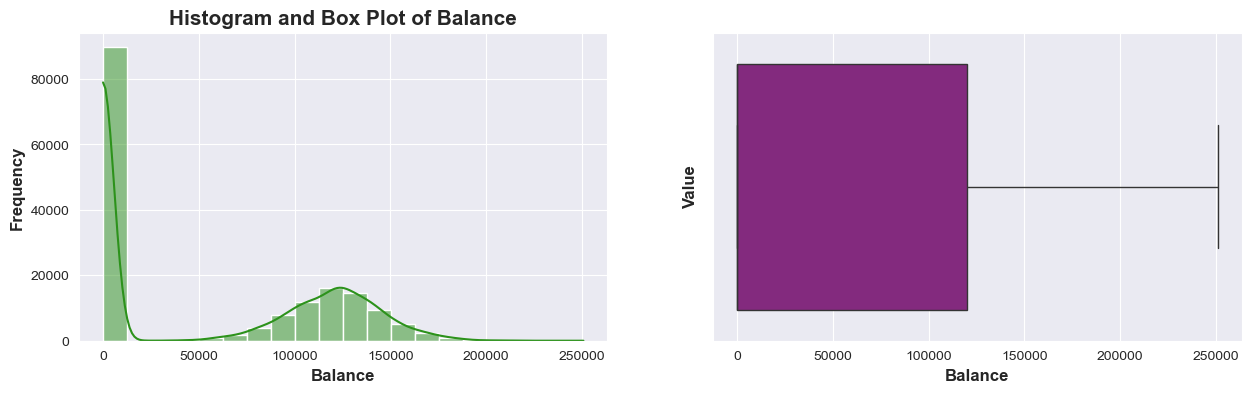

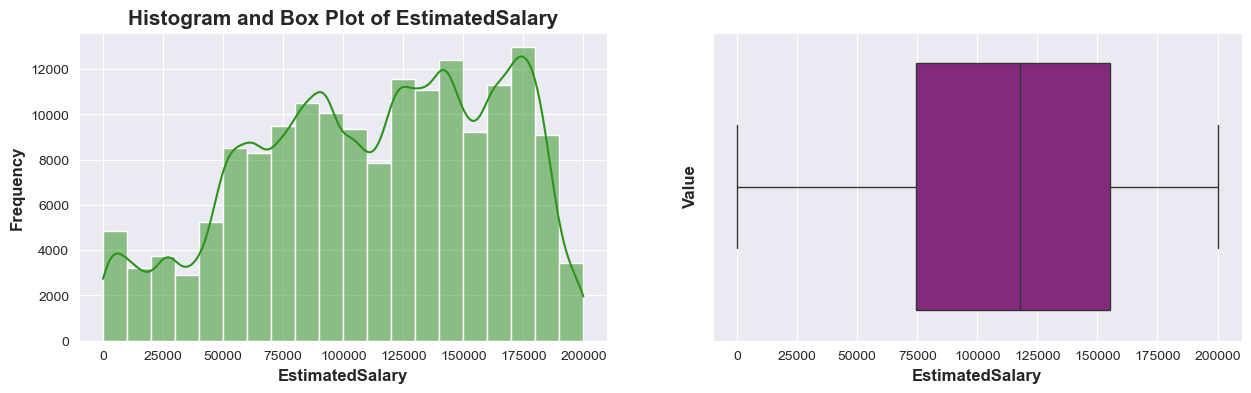

In [24]:
outlier_cols = df.select_dtypes('number').columns

#Creating a function of visualizing outliers using box and distribution plots
def plot_hist_box(data, column):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 4))
    sns.histplot(data=data, x=column, bins=20, kde=True, ax=ax1, color='#2c921b')
    sns.boxplot(data=data, x=column, ax=ax2, color='#921b8b')
    ax1.set_title(f"Histogram and Box Plot of {column}", size=15, weight='bold')
    ax1.set_xlabel(column, size=12, weight='bold')
    ax1.set_ylabel("Frequency", size=12, weight='bold')
    ax2.set_xlabel(column, size=12, weight='bold')
    ax2.set_ylabel("Value", size=12, weight='bold')
    plt.show()

#Showing all the columns in one action 
for col in outlier_cols:
    plot_hist_box(df, col)

Remove outliers:

In [25]:
def remove_outliers(data, columns, k=1.5):
    for column in columns:
        q1 = data[column].quantile(0.25)
        q3 = data[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - k * iqr
        upper_bound = q3 + k * iqr
        data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    return data

df = remove_outliers(df, outlier_cols)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 158400 entries, 0 to 165033
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   CreditScore      158400 non-null  int64   
 1   Geography        158400 non-null  category
 2   Gender           158400 non-null  category
 3   Age              158400 non-null  float64 
 4   Tenure           158400 non-null  category
 5   Balance          158400 non-null  float64 
 6   NumOfProducts    158400 non-null  category
 7   HasCrCard        158400 non-null  category
 8   IsActiveMember   158400 non-null  category
 9   EstimatedSalary  158400 non-null  float64 
 10  Exited           158400 non-null  category
dtypes: category(7), float64(3), int64(1)
memory usage: 7.1 MB


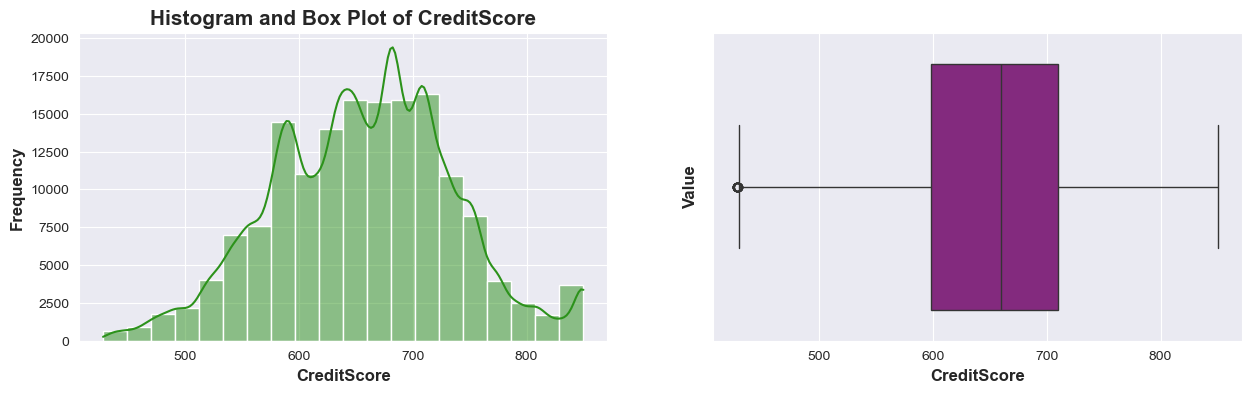

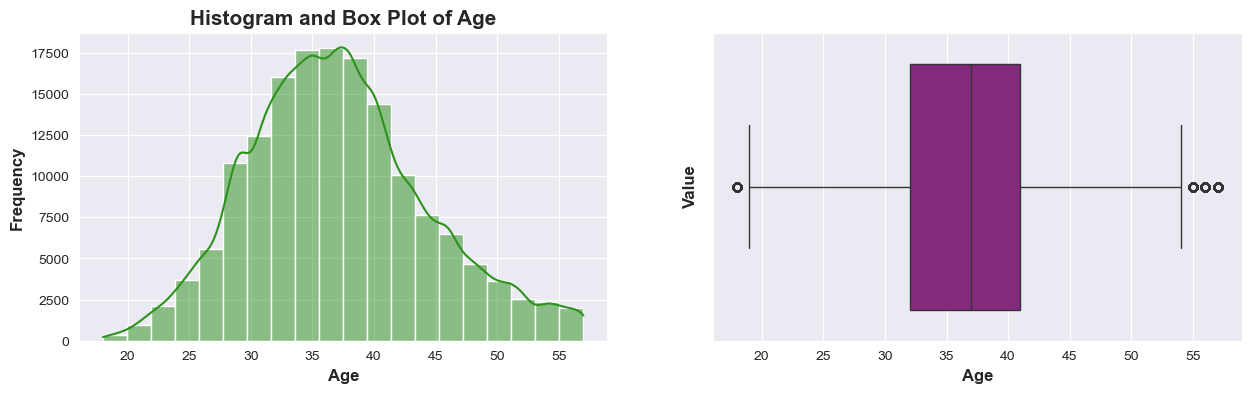

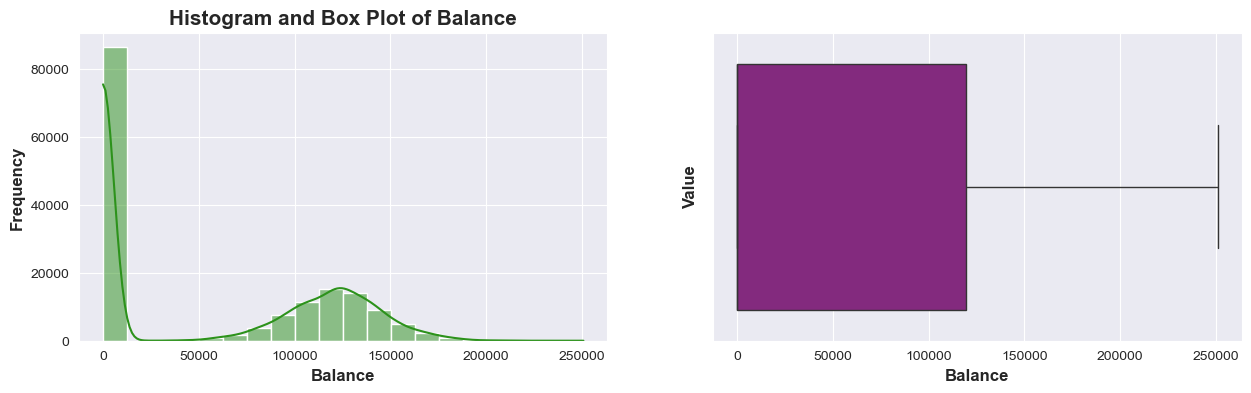

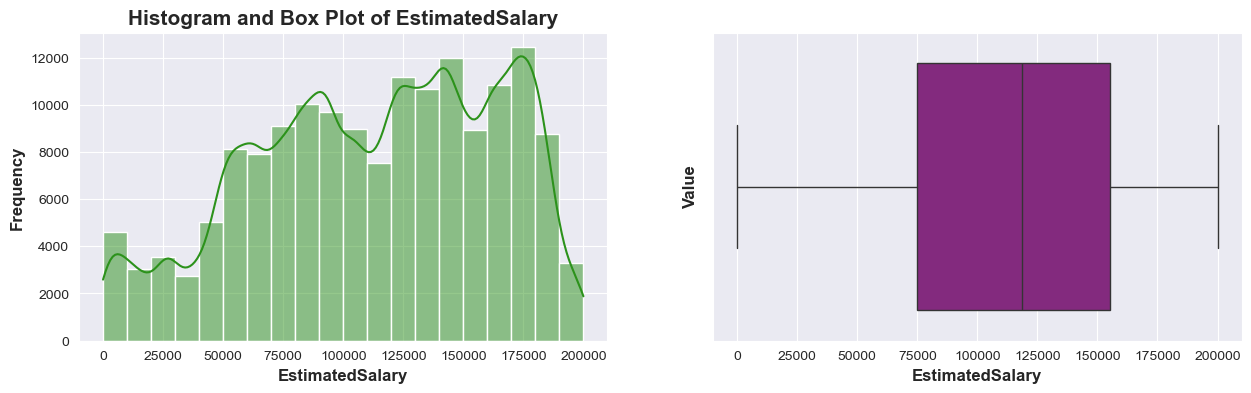

In [26]:
for col in outlier_cols:
    plot_hist_box(df, col)

**Bivariate Analysis**

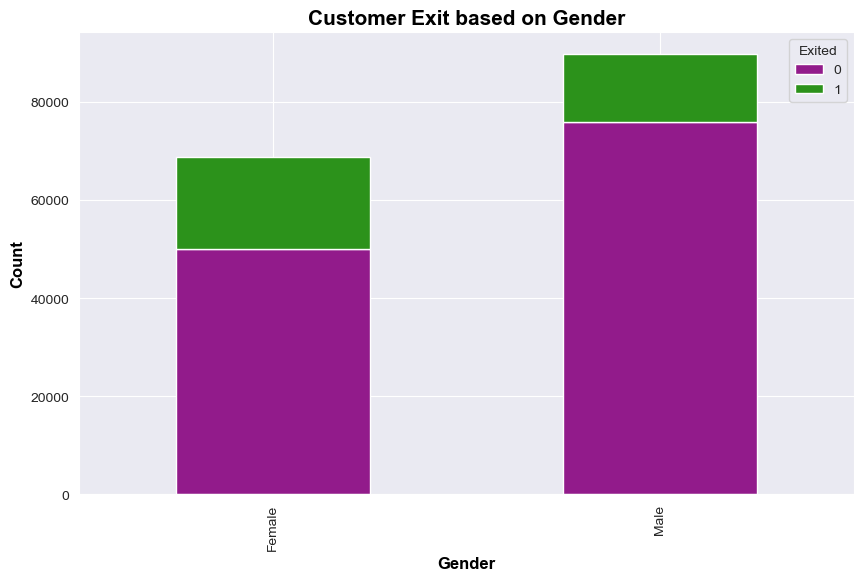

In [27]:
exit = df.groupby(
    ['Gender', 'Exited'], observed=False
).size().unstack()

colors = ['#921b8b', '#2c921b']
exit.plot(
    kind='bar', stacked=True, color=colors, figsize=(10,6)
)
plt.title(
    'Customer Exit based on Gender', fontsize=15, fontweight='bold', color='black'
)
plt.xlabel(
    'Gender', fontsize=12, fontweight='bold', color='black'
)
plt.ylabel(
    'Count', fontsize=12, fontweight='bold', color='black'
)
plt.show()

From the Customer Exit by Gender stacked plot:
* Most users across sexes are retained
* However, when classified by gender, more women are churned than men in comparison.

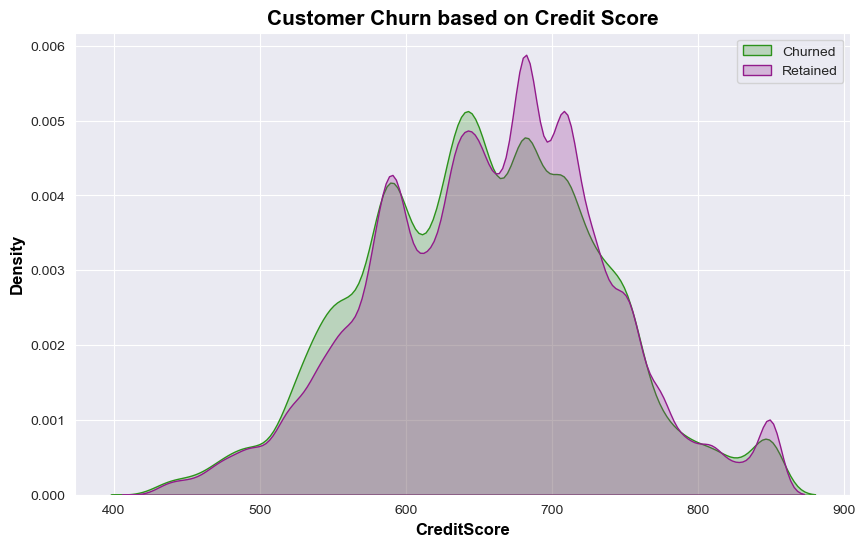

In [28]:
plt.figure(figsize=(10,6))
sns.kdeplot(df.loc[df['Exited']==1, 'CreditScore'], label='Churned', fill='1', color='#2c921b')
sns.kdeplot(df.loc[df['Exited']==0, 'CreditScore'], label='Retained', fill='1', color='#921b8b')
plt.title('Customer Churn based on Credit Score', fontsize=15, fontweight='bold', color='black')
plt.xlabel('CreditScore', fontsize=12, fontweight='bold', color='black')
plt.ylabel('Density', fontsize=12, fontweight='bold', color='black')
plt.legend()
plt.show()

From the churn by credit score density plot:
* There is more churn activity for customers with lower credit scores.
* In the mean/ median range, more customers are retained than churned.
* On the higher credit score range, more customers are retained than churned, although for the highest value credit score customers, churning is higher than retention.

In [29]:
def barPerc(df,xVar,ax):
    """
    barPerc(): Add percentage for hues to bar plots
    :param df: pandas dataframe: pd.DataFrame
    :param xVar: X variable: str
    :param ax: Axes object (for Seaborn Count plot/Bar plot or pandas bar plot)
    :return: 
    """
    # 1. how many X categories
    ## check for NaN and remove
    numX=len([x for x in df[xVar].unique() if x==x])

    # 2. The bars are created in hue order, organize them
    bars = ax.patches
    ## 2a. For each X variable
    for ind in range(numX):
        ## 2b. Get every hue bar
        ## ex. 8 X categories, 4 hues =>
        ## [0, 8, 16, 24] are hue bars for 1st X category
        hueBars=bars[ind:][::numX]
        ## 2c. Get the total height (for percentages)
        total = sum([x.get_height() for x in hueBars])

        # 3. Print the percentage on the bars
        for bar in hueBars:
            ax.text(bar.get_x() + bar.get_width()/2.,
                    bar.get_height(),
                    f'{bar.get_height()/total:.0%}',
                    ha="center",va="bottom")

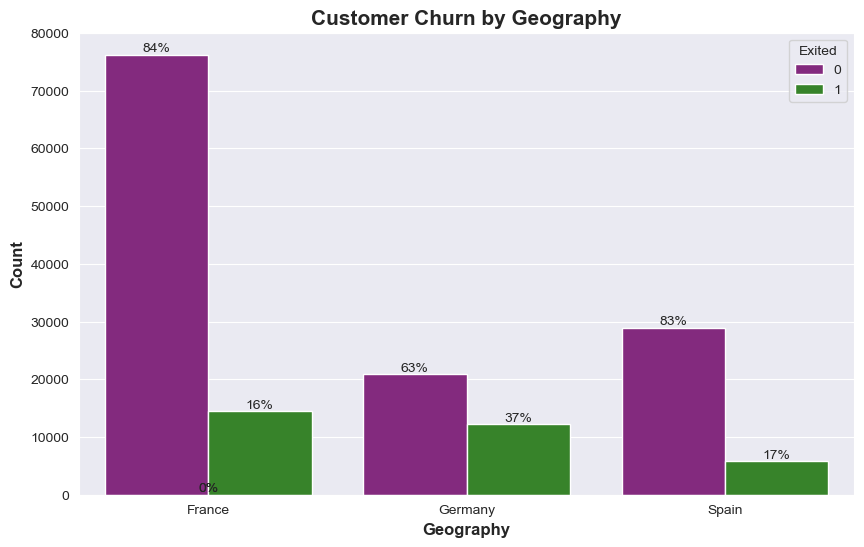

In [30]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x='Geography', hue='Exited', palette=colors)
plt.title('Customer Churn by Geography', fontsize=15, fontweight='bold')
plt.xlabel('Geography', fontsize=12, fontweight='bold')
plt.ylabel('Count', fontsize=12, fontweight='bold')

barPerc(df, 'Geography', ax)

From the churn by geography grouped bar plot:
* By count, churning and retention is highest in France. France is also the market with the most customers.
* For the two secondary markets (Germany and Spain), churning is significantly higher in Germany, even though market size for both countries is identical.
* Across all markets, churning is comparatively highest in Germany.
* Retention and churning is approximately the same in France and Spain by percentage comparison.

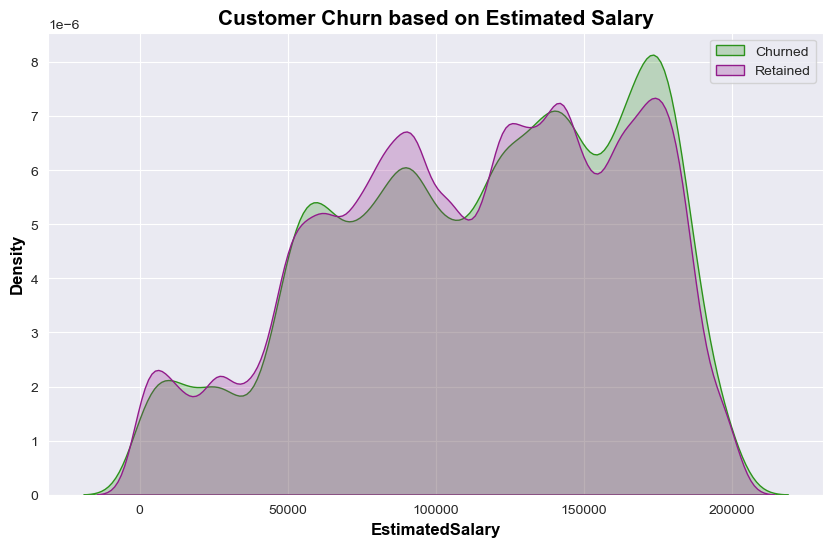

In [31]:
plt.figure(figsize=(10,6))
sns.kdeplot(df.loc[df['Exited']==1, 'EstimatedSalary'], label='Churned', fill='1', color='#2c921b')
sns.kdeplot(df.loc[df['Exited']==0, 'EstimatedSalary'], label='Retained', fill='1', color='#921b8b')
plt.title('Customer Churn based on Estimated Salary', fontsize=15, fontweight='bold', color='black')
plt.xlabel('EstimatedSalary', fontsize=12, fontweight='bold', color='black')
plt.ylabel('Density', fontsize=12, fontweight='bold', color='black')
plt.legend()
plt.show()

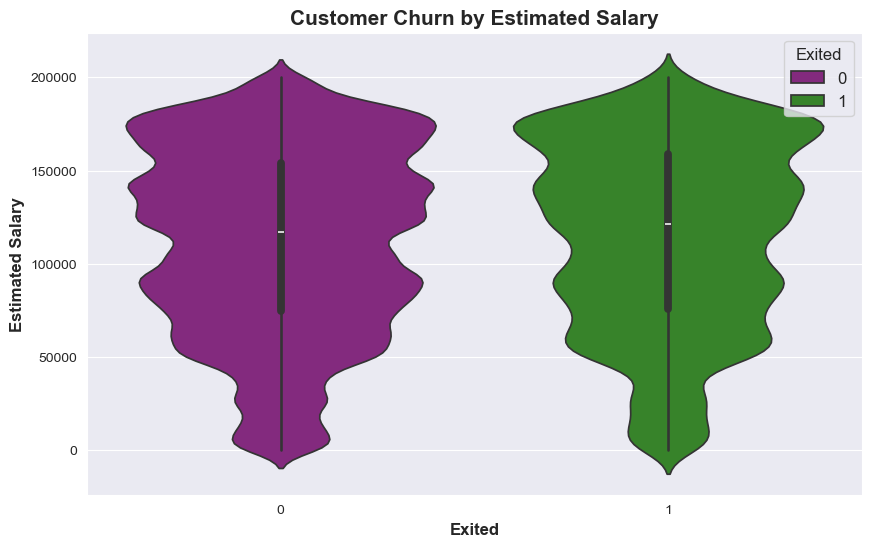

In [32]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='Exited', y='EstimatedSalary', hue='Exited', palette=colors)
plt.title('Customer Churn by Estimated Salary', fontsize=15, fontweight='bold')
plt.xlabel('Exited', fontsize=12, fontweight='bold')
plt.ylabel('Estimated Salary', fontsize=12, fontweight='bold')
plt.legend(title='Exited', fontsize=12, title_fontsize=12)
plt.show()

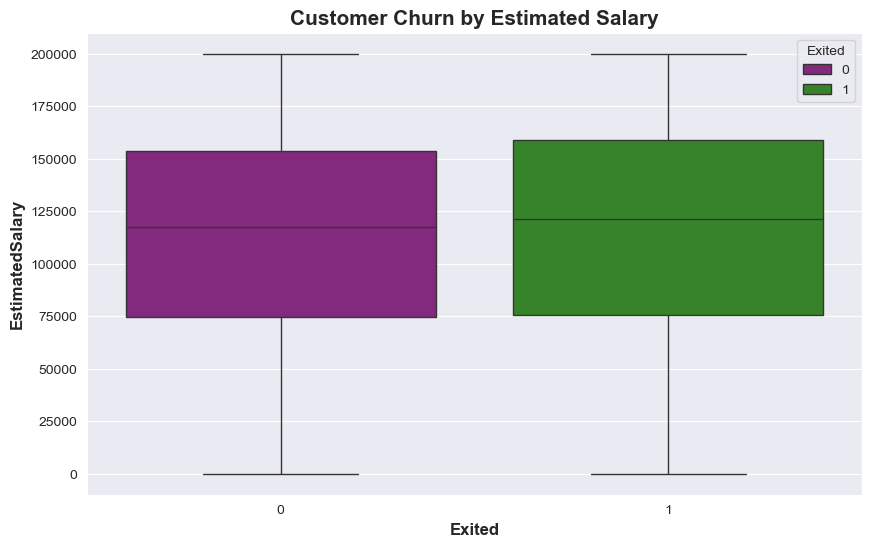

In [33]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Exited', y='EstimatedSalary', hue='Exited', palette=colors)
plt.title('Customer Churn by Estimated Salary', fontsize=15, fontweight='bold')
plt.xlabel('Exited', fontsize=12, fontweight='bold')
plt.ylabel('EstimatedSalary', fontsize=12, fontweight='bold')
plt.show()

From the plots of customer churn by estimated salary:
* The distribution of estimated salary when segmented into churns is approximately identical. 
* however, the IQR spread for churn has slightly higher estimated salary values, implying that churn is slightly higher for higher income earners.

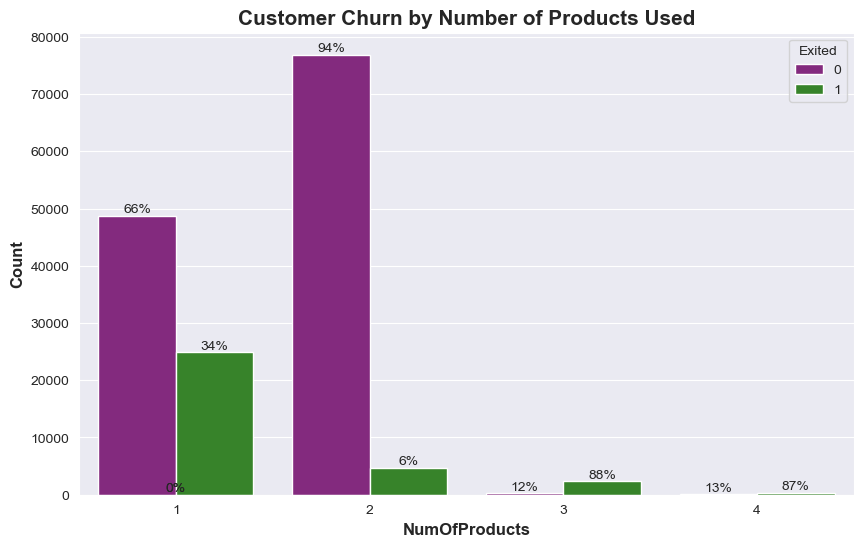

In [34]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(
    data=df, x='NumOfProducts', hue='Exited', palette=colors
)
plt.title(
    'Customer Churn by Number of Products Used', fontsize=15, fontweight='bold'
)
plt.xlabel('NumOfProducts', fontsize=12, fontweight='bold')
plt.ylabel('Count', fontsize=12, fontweight='bold')

barPerc(df, 'NumOfProducts', ax)

From the grouped bar plot of customer churn by number of products used:
* Churn is the lowest among customers who use two products
* the highest churns are by customers using more than two products.
* This implies that when customers use more than two products from the bank, they are more likely to churn. 
* However, when they use less than two products, they are more likely to churn than when they use two products.

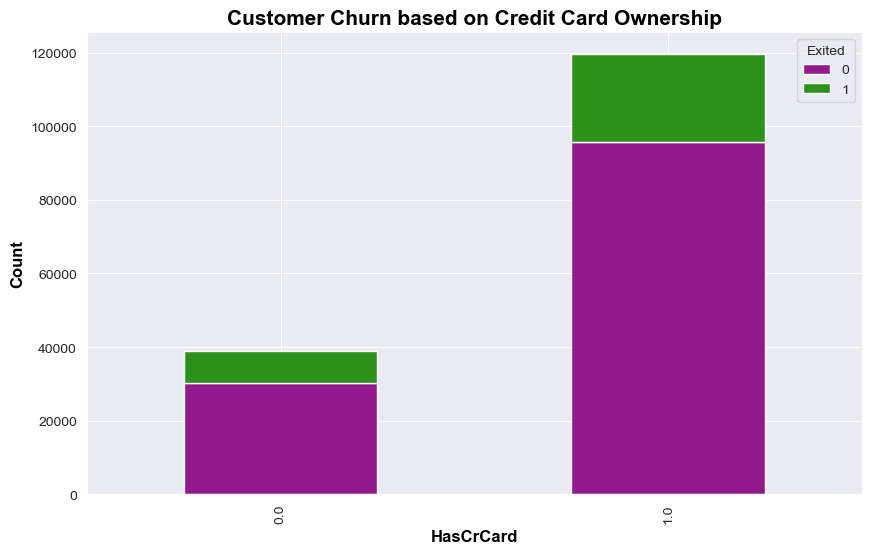

In [35]:
exit = df.groupby(
    ['HasCrCard', 'Exited'], observed=False
).size().unstack()

colors = ['#921b8b', '#2c921b']
exit.plot(
    kind='bar', stacked=True, color=colors, figsize=(10,6)
)
plt.title(
    'Customer Churn based on Credit Card Ownership', fontsize=15, fontweight='bold', color='black'
)
plt.xlabel(
    'HasCrCard', fontsize=12, fontweight='bold', color='black'
)
plt.ylabel(
    'Count', fontsize=12, fontweight='bold', color='black'
)
plt.show()

From the stacked bar plot of customer churn by credit card ownership:
* Churn is significantly higher among customers with credit cards.
* More of the bank's customers have credit cards.

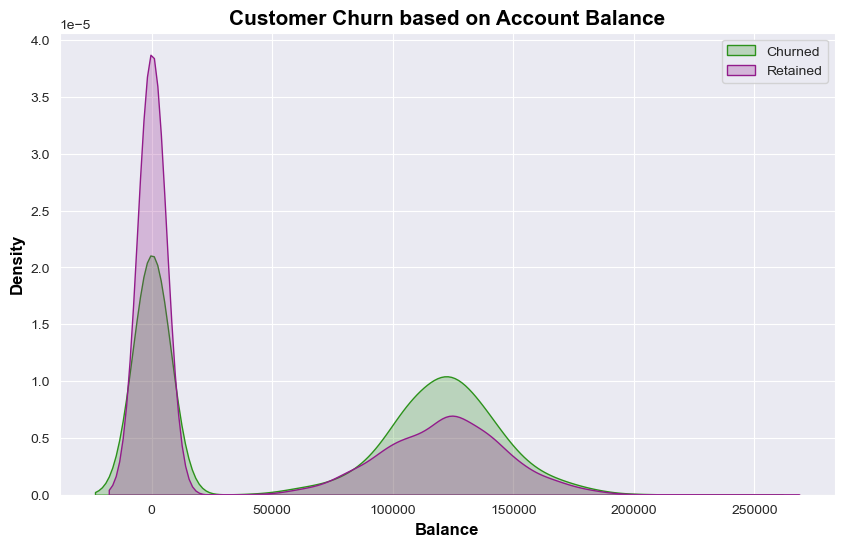

In [36]:
plt.figure(figsize=(10,6))
sns.kdeplot(df.loc[df['Exited']==1, 'Balance'], label='Churned', fill='1', color='#2c921b')
sns.kdeplot(df.loc[df['Exited']==0, 'Balance'], label='Retained', fill='1', color='#921b8b')
plt.title('Customer Churn based on Account Balance', fontsize=15, fontweight='bold', color='black')
plt.xlabel('Balance', fontsize=12, fontweight='bold', color='black')
plt.ylabel('Density', fontsize=12, fontweight='bold', color='black')
plt.legend()
plt.show()

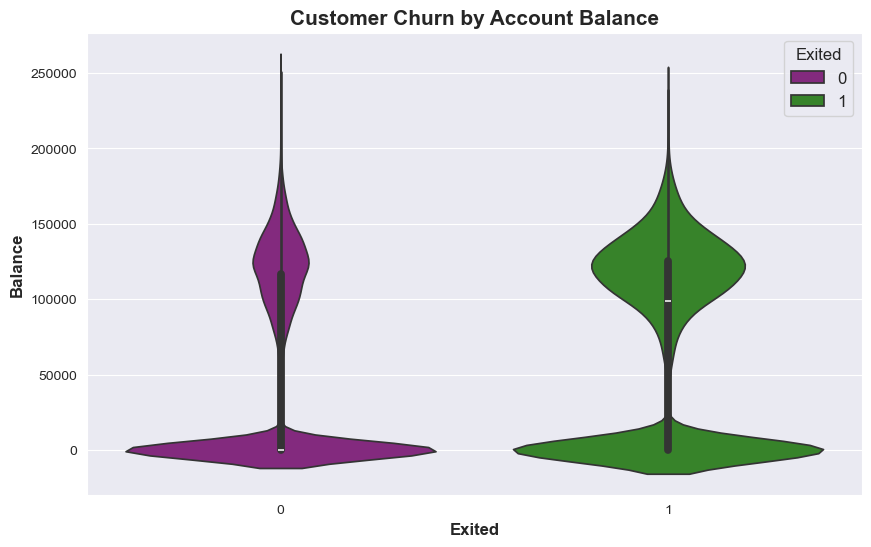

In [37]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='Exited', y='Balance', hue='Exited', palette=colors)
plt.title('Customer Churn by Account Balance', fontsize=15, fontweight='bold')
plt.xlabel('Exited', fontsize=12, fontweight='bold')
plt.ylabel('Balance', fontsize=12, fontweight='bold')
plt.legend(title='Exited', fontsize=12, title_fontsize=12)
plt.show()

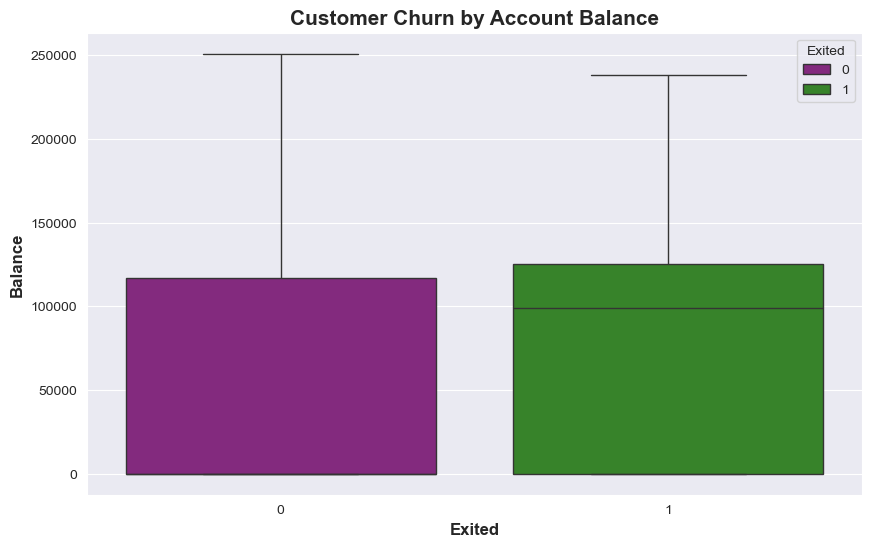

In [38]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Exited', y='Balance', hue='Exited', palette=colors)
plt.title('Customer Churn by Account Balance', fontsize=15, fontweight='bold')
plt.xlabel('Exited', fontsize=12, fontweight='bold')
plt.ylabel('Balance', fontsize=12, fontweight='bold')
plt.show()

From the Account Balance plots:
* A significant number of customers have a zero account balance.
* The bank is more likely to retain customers with zero account balances.
* For the customers with positive balances, churn is more likely than not.

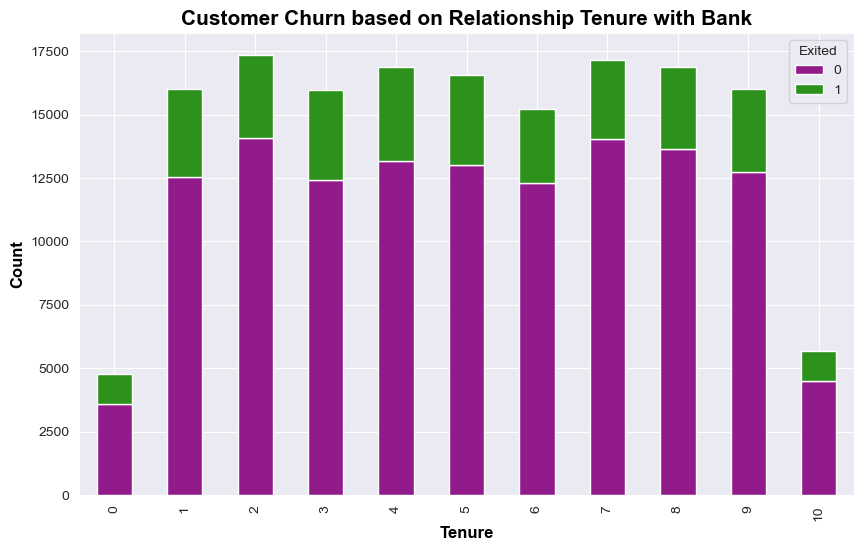

In [39]:
exit = df.groupby(
    ['Tenure', 'Exited'], observed=False
).size().unstack()

colors = ['#921b8b', '#2c921b']
exit.plot(
    kind='bar', stacked=True, color=colors, figsize=(10,6)
)
plt.title(
    'Customer Churn based on Relationship Tenure with Bank', fontsize=15, fontweight='bold', color='black'
)
plt.xlabel(
    'Tenure', fontsize=12, fontweight='bold', color='black'
)
plt.ylabel(
    'Count', fontsize=12, fontweight='bold', color='black'
)
plt.show()

From the Tenure stacked plot:
* Across all tenures, retention is more likely than churn
* However, churn is least likely for customers with less than 1-year tenure and 10+ year tenure relationship  with the bank. 

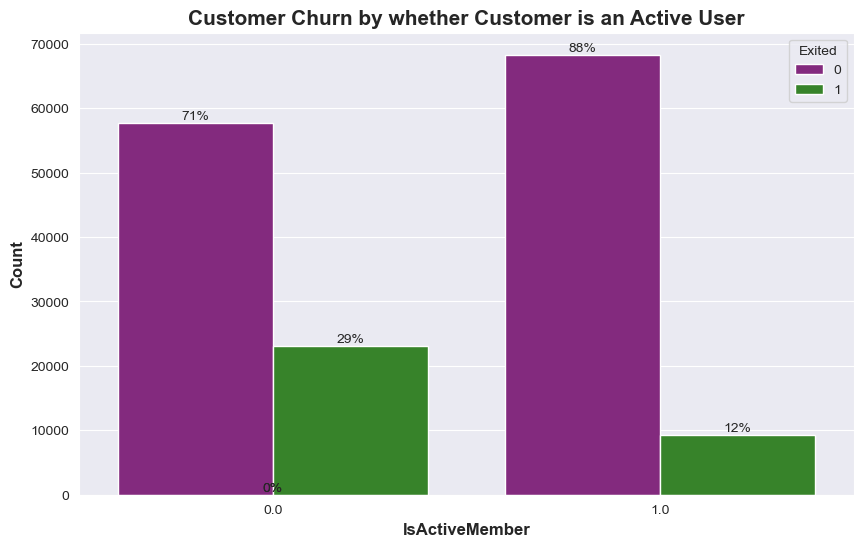

In [40]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(
    data=df, x='IsActiveMember', hue='Exited', palette=colors
)
plt.title(
    'Customer Churn by whether Customer is an Active User', fontsize=15, fontweight='bold'
)
plt.xlabel('IsActiveMember', fontsize=12, fontweight='bold')
plt.ylabel('Count', fontsize=12, fontweight='bold')

barPerc(df, 'IsActiveMember', ax)

From the grouped bar plot of active members:
* Churn is twice as likely for inactive members than for active members.

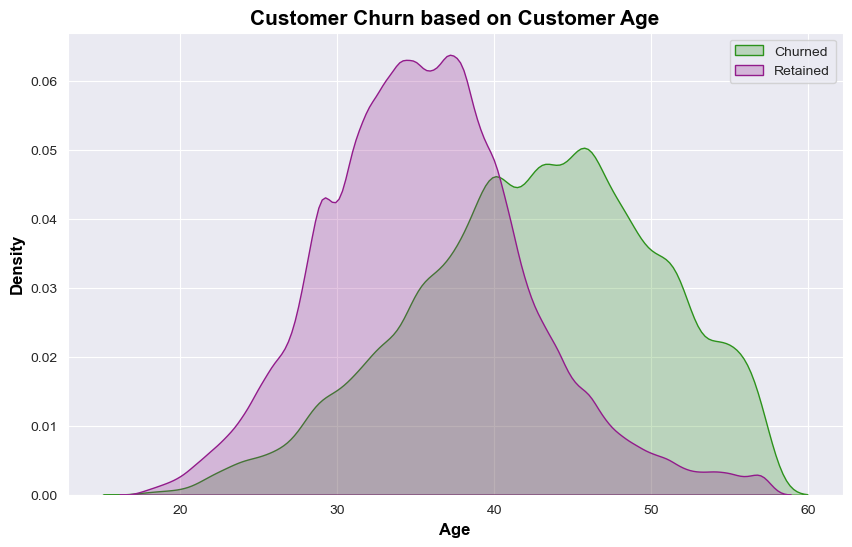

In [41]:
plt.figure(figsize=(10,6))
sns.kdeplot(df.loc[df['Exited']==1, 'Age'], label='Churned', fill='1', color='#2c921b')
sns.kdeplot(df.loc[df['Exited']==0, 'Age'], label='Retained', fill='1', color='#921b8b')
plt.title('Customer Churn based on Customer Age', fontsize=15, fontweight='bold', color='black')
plt.xlabel('Age', fontsize=12, fontweight='bold', color='black')
plt.ylabel('Density', fontsize=12, fontweight='bold', color='black')
plt.legend()
plt.show()

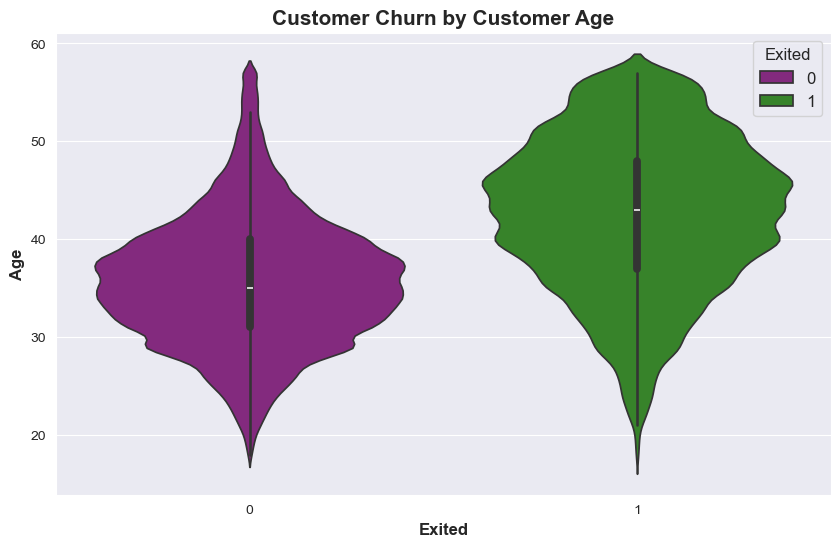

In [42]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='Exited', y='Age', hue='Exited', palette=colors)
plt.title('Customer Churn by Customer Age', fontsize=15, fontweight='bold')
plt.xlabel('Exited', fontsize=12, fontweight='bold')
plt.ylabel('Age', fontsize=12, fontweight='bold')
plt.legend(title='Exited', fontsize=12, title_fontsize=12)
plt.show()

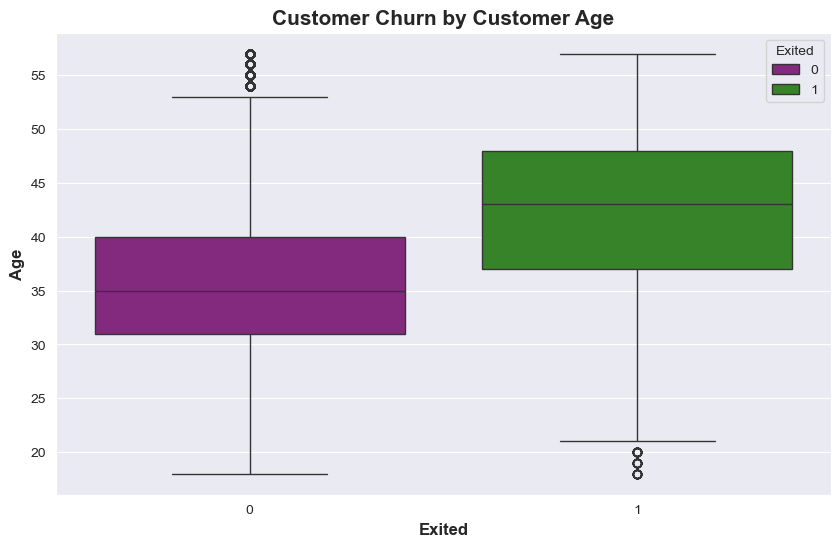

In [43]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Exited', y='Age', hue='Exited', palette=colors)
plt.title('Customer Churn by Customer Age', fontsize=15, fontweight='bold')
plt.xlabel('Exited', fontsize=12, fontweight='bold')
plt.ylabel('Age', fontsize=12, fontweight='bold')
plt.show()

From the plots of customer churn by age:
* Churn is significantly higher among customers above 40 years old.
* This may be related to the higher churn rate among higher income earners who are more likely in the 40+ age range.

### Statistical Testing

We'll test the following questions:
1. Does a customer's gender have an impact on churn?
2. Is there a significant difference in churn rates between customers who have and do not have credit cards?
3. Does a customer's location have an impact on churn rates?
4. Is there a significant different in churn rate between active and inactive members?
5. Does the number of bank products used by a customer have an impact on churn?
6. Does the length of customer's relationship with the bank affect churn rates?
7. Does a customer's credit score have a significant impact on churn?
8. Does a customer's age have a significant impact on churn?
9. Does a customer's account balance have a significant impact on churn?
10. Does a customer's estimated salary have a significant impact on churn?

**Hypothesis Testing**


##### Question 1
Statistical Question: Does a customer's gender have an impact on churn?
Null Hypothesis: A customer's gender does not have a significant impact on churn.

Alternative Hypothesis: A customer's gender has a significant impact on churn.

p-value alpha: 0.05. If the resulting p-value is less than or equal to alpha, we reject the null hypothesis and accept the alternative hypothesis.

Hypothesis test: A suitable hypothesis test for this scenario could be the chi-squared test of independence. This test can determine whether there is a statistically significant association between two categorical variables.

Result: We accept the alternative hypothesis that gender has a significant impact on Churn. Women are more likely to churn than men.

In [44]:
# Create a contingency table
contingency_table = pd.crosstab(df.Gender, df.Exited)

# Print the contingency table
display(contingency_table)

# Perform chi-square test
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

# Print the p-value
print('P-value: ', p_val)
if p_val <= 0.05:
    print('We reject the null hypothesis.')
else:
    print('We fail to reject the null hypothesis.')

Exited,0,1
Gender,,
Female,50081,18657
Male,75904,13758


P-value:  0.0
We reject the null hypothesis.


##### Question 2
Statistical Question: Is there a significant difference in churn rates between customers who have and do not have credit cards?

Null Hypothesis: There is no significant difference in churn rates between customers who have and do not have credit cards.

Alternative Hypothesis: There is a significant difference in churn rates between customers who have and do not have credit cards.

p-value alpha: 0.05. If the resulting p-value is less than or equal to alpha, we reject the null hypothesis and accept the alternative hypothesis.

Hypothesis test: A suitable hypothesis test for this scenario could be the chi-squared test of independence. This test can determine whether there is a statistically significant association between two categorical variables.

Result: We accept the alternative hypothesis that having a credit card has a significant impact on Churn. Customers with credit cards are more likely to churn than those without.

In [45]:
cont_table = pd.crosstab(df.HasCrCard, df.Exited)

chi2_stat, p_val, dof, exp_freq = chi2_contingency(cont_table)
display(cont_table)

print('P-value:', p_val)
if p_val < 0.05:
    print('We reject the null hypothesis.')
else:
    print('We fail to reject the null hypothesis.')

Exited,0,1
HasCrCard,,
0.0,30322,8561
1.0,95663,23854


P-value: 2.478788503408182e-18
We reject the null hypothesis.


##### Question 3
Statistical Question: Does a customer's location have an impact on churn rates?

Null Hypothesis: A customer's location does not have a significant impact on churn.

Alternative Hypothesis: A customer's location has a significant impact on churn.

p-value alpha: 0.05. If the resulting p-value is less than or equal to alpha, we reject the null hypothesis and accept the alternative hypothesis.

Hypothesis test: A suitable hypothesis test for this scenario could be the chi-squared test of independence. This test can determine whether there is a statistically significant association between two or more categorical variables.

Result: We accept the alternative hypothesis that a customer's location has a significant impact on Churn.

In [46]:
contingency_table = pd.crosstab(df.Geography, df.Exited)
display(contingency_table)

chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

print('P-value: ', p_val)
if p_val <= 0.05:
    print('We reject the null hypothesis.')
else:
    print('We fail to reject the null hypothesis.')

Exited,0,1
Geography,,
France,76204,14454
Germany,20823,12198
Spain,28958,5763


P-value:  0.0
We reject the null hypothesis.


##### Question 4
Statistical Question: Is there a significant difference in churn rate between active and inactive members?

Null Hypothesis: There is no significant difference in churn rates between active and inactive members.

Alternative Hypothesis: There is a significant difference in churn rates between active and inactive members.

p-value alpha: 0.05. If the resulting p-value is less than or equal to alpha, we reject the null hypothesis and accept the alternative hypothesis.

Hypothesis test: A suitable hypothesis test for this scenario could be the chi-squared test of independence. This test can determine whether there is a statistically significant association between two or more categorical variables.

Result: We accept the alternative hypothesis that whether a customer is active significantly impacts churn rate.

In [47]:
contingency_table = pd.crosstab(df.IsActiveMember, df.Exited)
display(contingency_table)

chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

print('P-value: ', p_val)
if p_val <= 0.05:
    print('We reject the null hypothesis.')
else:
    print('We fail to reject the null hypothesis.')

Exited,0,1
IsActiveMember,,
0.0,57707,23128
1.0,68278,9287


P-value:  0.0
We reject the null hypothesis.


##### Question 5
Statistical Question: Does the number of bank products used by a customer have an impact on churn?

Null Hypothesis: The number of bank products used by a customer does not have a significant impact on churn.

Alternative Hypothesis: The number of bank products used by a customer has a significant impact on churn.


p-value alpha: 0.05. If the resulting p-value is less than or equal to alpha, we reject the null hypothesis and accept the alternative hypothesis.

Hypothesis test: A suitable hypothesis test for this scenario could be the chi-squared test of independence. This test can determine whether there is a statistically significant association between two or more categorical variables.

Result: We accept the alternative hypothesis that number of products used significantly impacts churn rate.

In [48]:
contingency_table = pd.crosstab(df.NumOfProducts, df.Exited)
display(contingency_table)

chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

print('P-value: ', p_val)
if p_val <= 0.05:
    print('We reject the null hypothesis.')
else:
    print('We fail to reject the null hypothesis.')

Exited,0,1
NumOfProducts,,
1,48736,24938
2,76875,4744
3,318,2355
4,56,378


P-value:  0.0
We reject the null hypothesis.


##### Question 6
Statistical Question: Does the length of customer's relationship with the bank affect churn rates?

Null Hypothesis: The length of customer's relationship with the bank does not have a significant impact on churn.

Alternative Hypothesis: The length of customer's relationship with the bank has a significant impact on churn.

p-value alpha: 0.05. If the resulting p-value is less than or equal to alpha, we reject the null hypothesis and accept the alternative hypothesis.

Hypothesis test: A suitable hypothesis test for this scenario would be a logistic regression analysis. Logistic regression is a statistical method used to analyze the relationship between a binary dependent variable, such as churn (yes/no), and one or more independent variables, such as tenure. In this case, the logistic regression analysis can help determine whether there is a significant association between churn and tenure, after controlling for other factors that may affect churn. The output of the logistic regression model provides a coefficient for the tenure variable, along with its significance level (p-value).

Result: We accept the alternative hypothesis that the tenure of a customer's relationship with the bank significantly impacts churn rate. The pseudo R-squared value is very low, indicating that the model does not have a good fit to the data.

In [49]:
# create binary outcome variable
data = df.copy()

# fit logistic regression model
X = data.Tenure
y = data.Exited
X = sm.add_constant(X) # add intercept term
model = sm.Logit(y, X).fit()

# print model summary
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.506587
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 Exited   No. Observations:               158400
Model:                          Logit   Df Residuals:                   158398
Method:                           MLE   Df Model:                            1
Date:                Thu, 04 Jan 2024   Pseudo R-squ.:               0.0003575
Time:                        12:12:34   Log-Likelihood:                -80243.
converged:                       True   LL-Null:                       -80272.
Covariance Type:            nonrobust   LLR p-value:                 3.577e-14
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2736      0.013   -100.800      0.000      -1.298      -1.249
Tenure        -0.0168      0.

##### Question 7
Statistical Question: Does a customer's credit score have a significant impact on churn?

Null Hypothesis: A customer's credit score does not have a significant impact on churn.

Alternative Hypothesis: A customer's credit score has a significant impact on churn.

p-value alpha: 0.05. If the resulting p-value is less than or equal to alpha, we reject the null hypothesis and accept the alternative hypothesis.

Hypothesis test: A suitable hypothesis test for this scenario would be a logistic regression analysis. Logistic regression is a statistical method used to analyze the relationship between a binary dependent variable, such as churn (yes/no), and one or more independent variables, such as credit score. In this case, the logistic regression analysis can help determine whether there is a significant association between churn and credit score, after controlling for other factors that may affect churn. The output of the logistic regression model provides a coefficient for the credit score variable, along with its significance level (p-value).

Result: We accept the alternative hypothesis that the a customer's credit score significantly impacts churn rate. The pseudo R-squared value is very low, indicating that the model does not have a good fit to the data.

In [50]:
data = df.copy()

X = data.CreditScore
y = data.Exited
X = sm.add_constant(X) # add intercept term
model = sm.Logit(y, X).fit()

print(model.summary())

Optimization terminated successfully.
         Current function value: 0.506401
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 Exited   No. Observations:               158400
Model:                          Logit   Df Residuals:                   158398
Method:                           MLE   Df Model:                            1
Date:                Thu, 04 Jan 2024   Pseudo R-squ.:               0.0007235
Time:                        12:12:34   Log-Likelihood:                -80214.
converged:                       True   LL-Null:                       -80272.
Covariance Type:            nonrobust   LLR p-value:                 4.399e-27
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.8037      0.052    -15.559      0.000      -0.905      -0.702
CreditScore    -0.0008   7

##### Question 8
Statistical Question: Does a customer's age have a significant impact on churn?

Null Hypothesis: A customer's age does not have a significant impact on churn.

Alternative Hypothesis: A customer's age has a significant impact on churn.

p-value alpha: 0.05. If the resulting p-value is less than or equal to alpha, we reject the null hypothesis and accept the alternative hypothesis.

Hypothesis test: A suitable hypothesis test for this scenario would be a logistic regression analysis. Logistic regression is a statistical method used to analyze the relationship between a binary dependent variable, such as churn (yes/no), and one or more independent variables, such as age. In this case, the logistic regression analysis can help determine whether there is a significant association between churn and age, after controlling for other factors that may affect churn. The output of the logistic regression model provides a coefficient for the age variable, along with its significance level (p-value).

Result: We accept the alternative hypothesis that a customer's age significantly impacts churn rate. The pseudo R-squared value is low, indicating that the model explains about 14% of the variation in churn.

In [51]:
data = df.copy()

X = data.Age
y = data.Exited
X = sm.add_constant(X) # add intercept term
model = sm.Logit(y, X).fit()

print(model.summary())

Optimization terminated successfully.
         Current function value: 0.433693
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 Exited   No. Observations:               158400
Model:                          Logit   Df Residuals:                   158398
Method:                           MLE   Df Model:                            1
Date:                Thu, 04 Jan 2024   Pseudo R-squ.:                  0.1442
Time:                        12:12:35   Log-Likelihood:                -68697.
converged:                       True   LL-Null:                       -80272.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.7010      0.041   -164.538      0.000      -6.781      -6.621
Age            0.1369      0.

##### Question 9
Statistical Question: Does a customer's account balance have a significant impact on churn?

Null Hypothesis: A customer's account balance does not have a significant impact on churn.

Alternative Hypothesis: A customer's account balance has a significant impact on churn.

p-value alpha: 0.05. If the resulting p-value is less than or equal to alpha, we reject the null hypothesis and accept the alternative hypothesis.

Hypothesis test: A suitable hypothesis test for this scenario would be a logistic regression analysis. Logistic regression is a statistical method used to analyze the relationship between a binary dependent variable, such as churn (yes/no), and one or more independent variables, such as account balance. In this case, the logistic regression analysis can help determine whether there is a significant association between churn and account balance, after controlling for other factors that may affect churn. The output of the logistic regression model provides a coefficient for the account balance variable, along with its significance level (p-value).

Result: We accept the alternative hypothesis that a customer's account balance significantly impacts churn rate. The pseudo R-squared value is very low, indicating that the model does not have a good fit to the data.

In [52]:
data = df.copy()

X = data.Balance
y = data.Exited
X = sm.add_constant(X) # add intercept term
model = sm.Logit(y, X).fit()

print(model.summary())

Optimization terminated successfully.
         Current function value: 0.498615
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 Exited   No. Observations:               158400
Model:                          Logit   Df Residuals:                   158398
Method:                           MLE   Df Model:                            1
Date:                Thu, 04 Jan 2024   Pseudo R-squ.:                 0.01609
Time:                        12:12:35   Log-Likelihood:                -78981.
converged:                       True   LL-Null:                       -80272.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.6622      0.009   -182.908      0.000      -1.680      -1.644
Balance     4.988e-06   9.83e

##### Question 10
Statistical Question: Does a customer's estimated salary have a significant impact on churn?

Null Hypothesis: A customer's estimated salary does not have a significant impact on churn.

Alternative Hypothesis: A customer's estimated salary has a significant impact on churn.

p-value alpha: 0.05. If the resulting p-value is less than or equal to alpha, we reject the null hypothesis and accept the alternative hypothesis.

Hypothesis test: A suitable hypothesis test for this scenario would be a logistic regression analysis. Logistic regression is a statistical method used to analyze the relationship between a binary dependent variable, such as churn (yes/no), and one or more independent variables, such as estimated salary. In this case, the logistic regression analysis can help determine whether there is a significant association between churn and estimated salary, after controlling for other factors that may affect churn. The output of the logistic regression model provides a coefficient for the estimated salary variable, along with its significance level (p-value).

Result: We accept the alternative hypothesis that a customer's estimated salary significantly impacts churn rate. The pseudo R-squared value is very low, indicating that the model does not have a good fit to the data.

In [53]:
data = df.copy()

X = data.EstimatedSalary
y = data.Exited
X = sm.add_constant(X) # add intercept term
model = sm.Logit(y, X).fit()

print(model.summary())

Optimization terminated successfully.
         Current function value: 0.506595
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 Exited   No. Observations:               158400
Model:                          Logit   Df Residuals:                   158398
Method:                           MLE   Df Model:                            1
Date:                Thu, 04 Jan 2024   Pseudo R-squ.:               0.0003411
Time:                        12:12:36   Log-Likelihood:                -80245.
converged:                       True   LL-Null:                       -80272.
Covariance Type:            nonrobust   LLR p-value:                 1.360e-13
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.4620      0.016    -94.159      0.000      -1.492      -1.432
EstimatedSalar

### Data Processing

**Encoding Categorical Variables**

In [54]:
le = LabelEncoder()
for col in df.select_dtypes('category').columns:
    df[col] = le.fit_transform(df[col])

df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,668,0,1,33.0,3,0.00,1,1,0,181449.97,0
1,627,0,1,33.0,1,0.00,1,1,1,49503.50,0
2,678,0,1,40.0,10,0.00,1,1,0,184866.69,0
3,581,0,1,34.0,2,148882.54,0,1,1,84560.88,0
4,716,2,1,33.0,5,0.00,1,1,1,15068.83,0


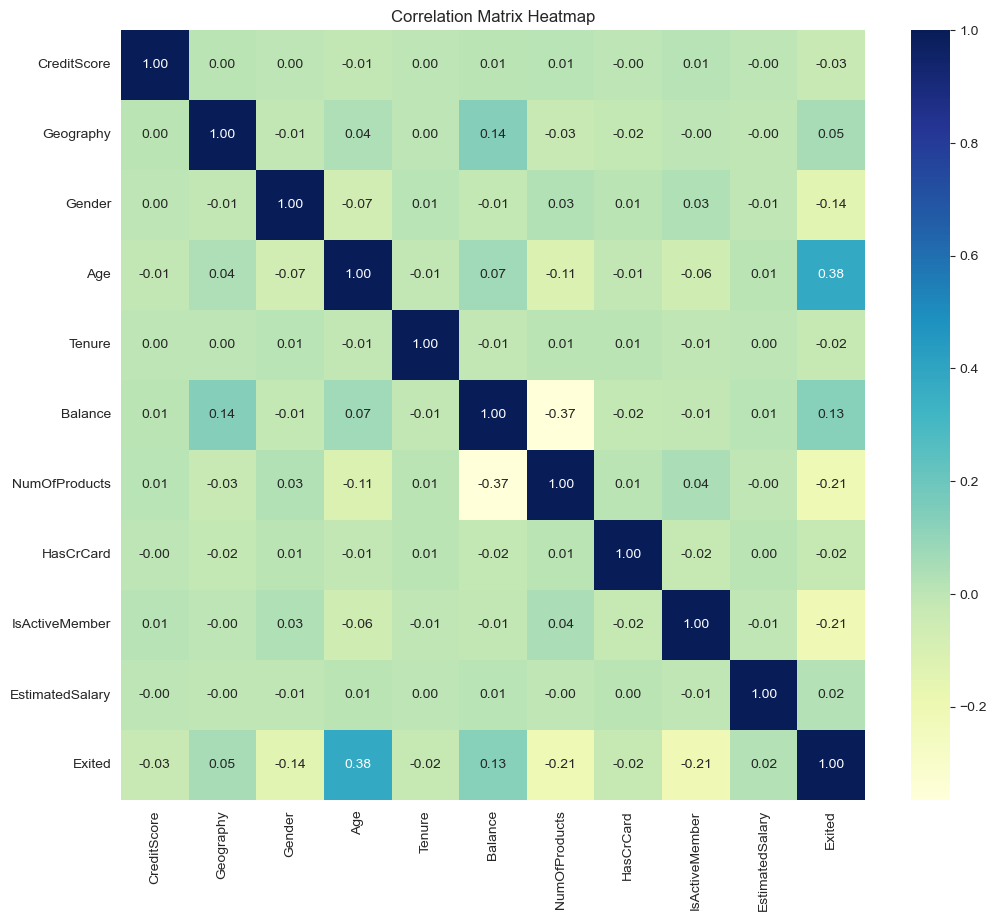

In [55]:
correlation_matrix = df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

**Feature Selection**

In [56]:
X, y = df.drop(columns=['Exited']), df.Exited

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Data Modeling

In [57]:
classifiers = [
    LogisticRegression(), SGDClassifier(), LinearSVC(dual='auto'), 
    # SVC(probability=True), 
    DecisionTreeClassifier(random_state=42), 
    RandomForestClassifier(random_state=42), 
    ExtraTreesClassifier(random_state=42), 
    GradientBoostingClassifier(random_state=42), 
    KNeighborsClassifier(), XGBClassifier()
]

In [58]:
results = []

for classifier in classifiers:
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    # Compute evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    
    results.append({
        'Classifier': classifier.__class__.__name__,
        'Accuracy': f'{accuracy:.2f}',
        'Precision': f'{precision:.2f}',
        'Recall': f'{recall:.2f}',
        'F1': f'{f1:.2f}',
        'ROC_AUC': f'{roc_auc:.2f}',
    })

df_results = pd.DataFrame(results)

# Display results DataFrame
display(df_results)

,Classifier,Accuracy,Precision,Recall,F1,ROC_AUC
0,LogisticRegression,0.80,0.56,0.17,0.26,0.57
1,SGDClassifier,0.80,0.44,0.00,0.00,0.50
2,LinearSVC,0.80,0.58,0.10,0.17,0.54
3,DecisionTreeClassifier,0.80,0.51,0.54,0.53,0.71
4,RandomForestClassifier,0.87,0.73,0.54,0.62,0.74
5,ExtraTreesClassifier,0.86,0.71,0.53,0.61,0.74
6,GradientBoostingClassifier,0.87,0.75,0.53,0.62,0.74
7,KNeighborsClassifier,0.77,0.29,0.10,0.15,0.52
8,XGBClassifier,0.87,0.74,0.55,0.63,0.75


The best model with the best ROC_AUC is the XGBoost model.

Re-workign the Linear Classifiers

In [59]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

linear_clfs = [
    LogisticRegression(), SGDClassifier(), LinearSVC(dual='auto'),
]

results = []

for classifier in linear_clfs:
    classifier.fit(X_train_scaled, y_train)
    y_pred = classifier.predict(X_test_scaled)

    # Compute evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    results.append({
        'Classifier': classifier.__class__.__name__,
        'Accuracy': f'{accuracy:.2f}',
        'Precision': f'{precision:.2f}',
        'Recall': f'{recall:.2f}',
        'F1': f'{f1:.2f}',
        'ROC_AUC': f'{roc_auc:.2f}',
    })

df_results = pd.DataFrame(results)

# Display results DataFrame
display(df_results)

,Classifier,Accuracy,Precision,Recall,F1,ROC_AUC
0,LogisticRegression,0.84,0.71,0.39,0.50,0.67
1,SGDClassifier,0.84,0.74,0.34,0.46,0.65
2,LinearSVC,0.84,0.73,0.34,0.47,0.66


**Handling Imbalance in the Target Variable**

In [60]:
df.Exited.value_counts()

Exited
0    125985
1     32415
Name: count, dtype: int64

In [64]:
# Instantiate the resampling algorithms
smote = SMOTE()
adasyn = ADASYN()

# Resample the data using SMOTE
X_smote, y_smote = smote.fit_resample(X_train, y_train)

# Resample the data using ADASYN
X_adasyn, y_adasyn = adasyn.fit_resample(X_train, y_train)

In [66]:
print("Before SAMPLING:",y_train.value_counts())
print('----------')
print("After SAMPLING:",y_smote.value_counts())

Before SAMPLING: Exited
0    100714
1     26006
Name: count, dtype: int64
----------
After SAMPLING: Exited
0    100714
1    100714
Name: count, dtype: int64


In [67]:
results = []

for classifier in classifiers:
    # Train and predict using SMOTE resampled data
    classifier.fit(X_smote, y_smote)
    y_pred = classifier.predict(X_test)

    # Compute evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    results.append({
        'Classifier': classifier.__class__.__name__,
        'Accuracy': f'{accuracy:.2f}',
        'Precision': f'{precision:.2f}',
        'Recall': f'{recall:.2f}',
        'F1': f'{f1:.2f}',
        'ROC_AUC': f'{roc_auc:.2f}',
    })

df_results = pd.DataFrame(results)

# Display results DataFrame
display(df_results)

,Classifier,Accuracy,Precision,Recall,F1,ROC_AUC
0,LogisticRegression,0.69,0.36,0.70,0.48,0.69
1,SGDClassifier,0.22,0.20,0.98,0.34,0.50
2,LinearSVC,0.69,0.37,0.70,0.48,0.69
3,DecisionTreeClassifier,0.79,0.49,0.56,0.52,0.71
4,RandomForestClassifier,0.85,0.62,0.63,0.63,0.77
5,ExtraTreesClassifier,0.84,0.59,0.66,0.62,0.77
6,GradientBoostingClassifier,0.84,0.59,0.70,0.64,0.79
7,KNeighborsClassifier,0.61,0.25,0.45,0.32,0.55
8,XGBClassifier,0.85,0.64,0.64,0.64,0.77


In [68]:
results = []

for classifier in classifiers:
    # Train and predict using ADASYN resampled data
    classifier.fit(X_adasyn, y_adasyn)
    y_pred = classifier.predict(X_test)

    # Compute evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    results.append({
        'Classifier': classifier.__class__.__name__,
        'Accuracy': f'{accuracy:.2f}',
        'Precision': f'{precision:.2f}',
        'Recall': f'{recall:.2f}',
        'F1': f'{f1:.2f}',
        'ROC_AUC': f'{roc_auc:.2f}',
    })

df_results = pd.DataFrame(results)

# Display results DataFrame
display(df_results)

,Classifier,Accuracy,Precision,Recall,F1,ROC_AUC
0,LogisticRegression,0.69,0.36,0.66,0.47,0.68
1,SGDClassifier,0.57,0.26,0.62,0.37,0.59
2,LinearSVC,0.68,0.36,0.71,0.47,0.69
3,DecisionTreeClassifier,0.79,0.49,0.56,0.52,0.71
4,RandomForestClassifier,0.85,0.62,0.64,0.63,0.77
5,ExtraTreesClassifier,0.84,0.58,0.66,0.62,0.77
6,GradientBoostingClassifier,0.84,0.58,0.70,0.64,0.79
7,KNeighborsClassifier,0.59,0.24,0.47,0.32,0.55
8,XGBClassifier,0.86,0.65,0.63,0.64,0.77


With SMOTE and ADASYN oversampling, the best models are the Ensemble Tree models.

### Feature Importance

**Feature Importance using Extra Trees Classifier**

From the Extra Trees model, the top3 features are Age, Estimated Salary and Credit score.

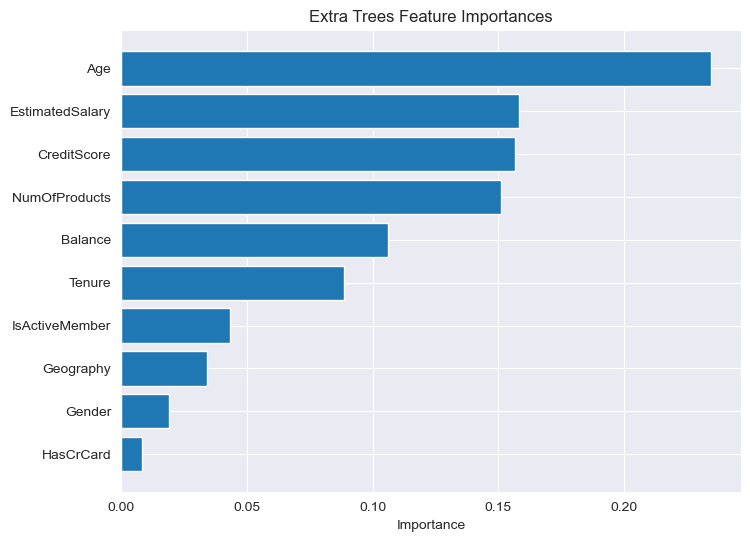

In [69]:
# Build the model
model = ExtraTreesClassifier(random_state=42)
model.fit(X, y)
feature_importance = model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(8, 6))
plt.barh(
    feature_importance_df['Feature'], feature_importance_df['Importance']
)
plt.xlabel('Importance')
plt.title('Extra Trees Feature Importances')
plt.gca().invert_yaxis()
plt.show()


**Feature Importance using Recursive Feature Elimination**

From the RFE model, the top 3 features are Estimated Salary, Balance and Credit score.

Selected Features:  Index(['Gender', 'NumOfProducts', 'IsActiveMember'], dtype='object')


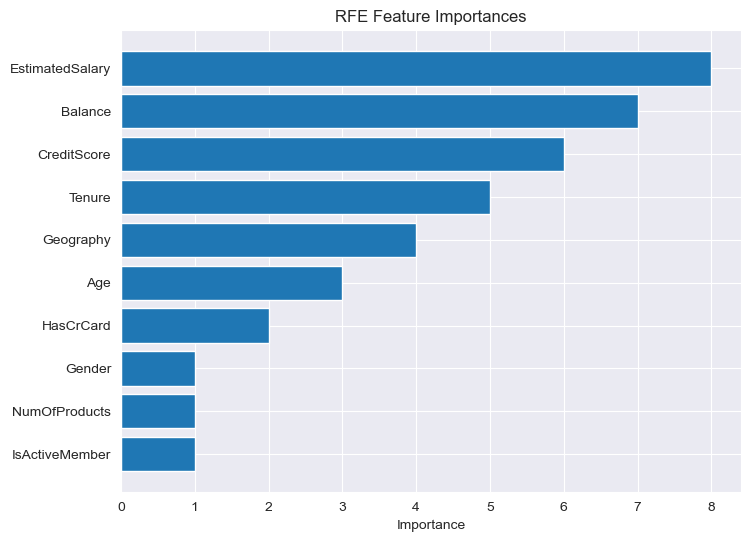

In [70]:
# Build the model
model = LogisticRegression(max_iter=1000)
rfe = RFE(model, n_features_to_select=3) # select top 3 features
fit = rfe.fit(X, y)

print("Selected Features: ", X.columns[fit.support_])

feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': rfe.ranking_})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(8, 6))
plt.barh(
    feature_importance_df['Feature'], feature_importance_df['Importance']
)
plt.xlabel('Importance')
plt.title('RFE Feature Importances')
plt.gca().invert_yaxis()
plt.show()

**Feature Importance Using SelectKBest**

From the SelectKBest model, the top 3 features are Age, Number of Products and Is Active Member.

Selected Features:  Index(['Age', 'NumOfProducts', 'IsActiveMember'], dtype='object')


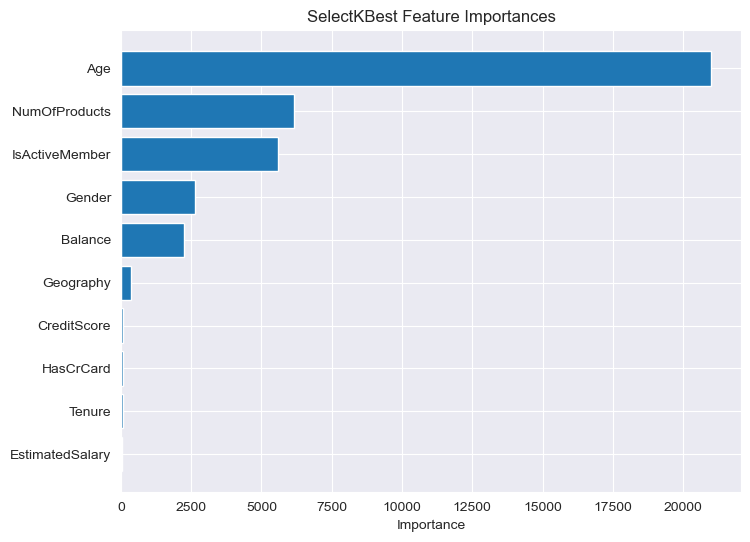

In [71]:
# Create an instance of SelectKBest with chi2 scoring function
selector = SelectKBest(f_classif, k=3)

# Fit the selector on the training set
X_train_selected = selector.fit_transform(X_train, y_train)

# Print the selected features
print("Selected Features: ", X_train.columns[selector.get_support()])

feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': selector.scores_})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 6))
plt.barh(
    feature_importance_df['Feature'], feature_importance_df['Importance']
)
plt.xlabel('Importance')
plt.title('SelectKBest Feature Importances')
plt.gca().invert_yaxis()
plt.show()

### Model Testing

**Best Model**

We'll use the Random Forest SMOTE oversampled model for predictions

In [72]:
train = pd.read_csv('playground-series-s4e1/train.csv')
test = pd.read_csv('playground-series-s4e1/test.csv')

train = train.iloc[:, 3:].copy()
train = train.assign(
    HasCrCard=lambda x: x.HasCrCard.astype('category'),
    IsActiveMember=lambda x: x.IsActiveMember.astype('category'),
    Geography=lambda x: x.Geography.astype('category'),
    Gender=lambda x: x.Gender.astype('category'),
    NumOfProducts=lambda x: x.NumOfProducts.astype('category'),
    Tenure=lambda x: x.Tenure.astype('category'),
    Exited=lambda x: x.Exited.astype('category'),
)

X_test = test.iloc[:, 3:].copy()
X_test = X_test.assign(
    HasCrCard=lambda x: x.HasCrCard.astype('category'),
    IsActiveMember=lambda x: x.IsActiveMember.astype('category'),
    Geography=lambda x: x.Geography.astype('category'),
    Gender=lambda x: x.Gender.astype('category'),
    NumOfProducts=lambda x: x.NumOfProducts.astype('category'),
    Tenure=lambda x: x.Tenure.astype('category'),
)

def remove_outliers(data, columns, k=1.5):
    for column in columns:
        q1 = data[column].quantile(0.25)
        q3 = data[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - k * iqr
        upper_bound = q3 + k * iqr
        data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    return data

outlier_cols = train.select_dtypes('number').columns
train = remove_outliers(train, outlier_cols)

In [75]:
X, y = train.drop(columns=['Exited']), train.Exited

le = LabelEncoder()
for col in X.select_dtypes('category').columns:
    X[col] = le.fit_transform(X[col])
    X_test[col] = le.transform(X_test[col])

smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X, y)

In [76]:
clf = RandomForestClassifier(random_state=42)

clf.fit(X_smote, y_smote)
y_pred = pd.DataFrame(
    {'id':test.id, 'Exited':clf.predict(X_test)}
)
y_pred.head()

,id,Exited
0,165034,0
1,165035,1
2,165036,0
3,165037,0
4,165038,0


In [77]:
file_path = 'rf_smote_submission.csv'
y_pred.to_csv(file_path, index=False)

In [78]:
clf = GradientBoostingClassifier(random_state=42)

clf.fit(X_smote, y_smote)
y_pred = pd.DataFrame(
    {'id':test.id, 'Exited':clf.predict(X_test)}
)
y_pred.head()

,id,Exited
0,165034,0
1,165035,1
2,165036,0
3,165037,0
4,165038,0


In [79]:
file_path = 'gbt_smote_submission.csv'
y_pred.to_csv(file_path, index=False)